In [1]:
#without power transformation 
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub.playback import play
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = pd.read_excel(excel_path)

# Lists to store extracted features and ptau181 values for male patients
all_data = []
ptau181_values = []

# Loop through patient IDs in the DataFrame
for idx, row in data_df.iterrows():
    patient_id = row["PatientID"]
    sex = row["Sex"]
    
    # Filter data for male patients
    if sex != "M" and sex != "F" :
        continue
    
    # Iterate through audio files in the folder
    for filename in os.listdir(audio_folder):
        if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
            audio_filepath = os.path.join(audio_folder, filename)
            
            # Load the audio file
            y, sr = librosa.load(audio_filepath)
            
            # Extract Root Mean Square Energy
            rmse = librosa.feature.rms(y=y)
            rmse_mean = np.mean(rmse)
            
            # Extract Speech Rate (words per minute)
            speech_rate = len(librosa.effects.split(y)) / (len(y) / sr) * 60
            
            # Extract Harmonics-to-Noise Ratio (HNR) 
            # HNR measure how clear and smooth their voice sounds 
            hnr = librosa.effects.harmonic(y)
            hnr_mean = np.mean(hnr)
            
            # Extract Formants
            sound = AudioSegment.from_wav(audio_filepath)
            formants = sound.dBFS
            formants_mean = np.mean(formants)
            
            # Extract MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr)
            mfccs_mean = np.mean(mfccs)
            
            # Extract Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_mean = np.mean(mel_spectrogram)
            
            # Extract Spectral Centroid
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid_mean = np.mean(spectral_centroids)
            
            # Get the ptau181 value for the male patient
            ptau181_value = row["ptau181"]
            
            all_data.append([rmse_mean, speech_rate, hnr_mean, formants_mean, mfccs_mean, mel_spectrogram_mean, spectral_centroid_mean])
            ptau181_values.append(np.log(ptau181_value))
            
            break  # Break after finding the first matching audio file

# Convert the lists to NumPy arrays
X = np.array(all_data)
y = np.array(ptau181_values)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adding a constant to the independent variables matrix
X_train_with_const = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train_with_const).fit()

# Print the regression results
print(model.summary())

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     4.740
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           0.000111
Time:                        10:55:08   Log-Likelihood:                -59.154
No. Observations:                 118   AIC:                             134.3
Df Residuals:                     110   BIC:                             156.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9485      0.038     76.876      0.0

In [2]:
data_df

,PatientID,VisitNumber,sample_year,sample_dayssincebaseline,experiment_date,ab42,ttau,ptau181,platform,Status,Speech Data,Closest Visit Number,audio label,Sex,Average Label,AD
0,7173,6,2017,2542,2022-07-28,294.1,215.9,20.87,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1
1,7173,8,2019,3320,2022-07-29,308.0,217.2,21.17,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1
2,7210,3,2014,1128,2022-07-22,707.2,128.8,10.77,Elecsys,QCI,Y,11,QCI,M,QCI,1
3,7210,5,2016,2042,2022-11-15,613.3,131.0,11.47,Elecsys,QCI,Y,11,QCI,M,QCI,1
4,7471,5,2018,1955,2022-11-29,323.8,387.5,44.05,Elecsys,Normal,Y,9,Normal,M,QCI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,10546,0,2023,93,2023-02-13,919.8,177.6,16.07,Elecsys,Normal,Y,0,Normal,M,Normal,N
144,10549,0,2022,87,2023-02-13,1778.0,225.9,19.52,Elecsys,Normal,Y,0,Normal,F,Normal,N
145,10554,0,2022,32,2023-02-13,837.2,120.9,10.37,Elecsys,Normal,NaN,0,Normal,F,Normal,N
146,10555,0,2022,15,2023-02-13,314.6,192.1,18.43,Elecsys,Dementia,NaN,0,Dementia,F,Dementia,1


In [3]:
# Calculate the ratio of ptau181 to ab42 and add it as a new column
data_df["ratio"] = data_df["ptau181"] / data_df["ab42"]


In [4]:
import pandas as pd

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = pd.read_excel(excel_path)

# Calculate the ratio of ptau181 to ab42 and add it as a new column
data_df["ratio"] = data_df["ptau181"] / data_df["ab42"]

# Now you can use data_df with the new "ratio" column
print(data_df.head())  # Check the first few rows to verify the new column


   PatientID  VisitNumber  sample_year  sample_dayssincebaseline  \
0       7173            6         2017                      2542   
1       7173            8         2019                      3320   
2       7210            3         2014                      1128   
3       7210            5         2016                      2042   
4       7471            5         2018                      1955   

  experiment_date   ab42   ttau  ptau181 platform    Status Speech Data  \
0      2022-07-28  294.1  215.9    20.87  Elecsys  Dementia           Y   
1      2022-07-29  308.0  217.2    21.17  Elecsys  Dementia           Y   
2      2022-07-22  707.2  128.8    10.77  Elecsys       QCI           Y   
3      2022-11-15  613.3  131.0    11.47  Elecsys       QCI           Y   
4      2022-11-29  323.8  387.5    44.05  Elecsys    Normal           Y   

   Closest Visit Number audio label Sex Average Label AD     ratio  
0                    11    Dementia   F      Dementia  1  0.070962  
1 

In [9]:
import pandas as pd

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = pd.read_excel(excel_path)

# Calculate the ratio of ptau181 to ab42 and add it as a new column
data_df["ratio"] = data_df["ptau181"] / data_df["ab42"]

data_df


,PatientID,VisitNumber,sample_year,sample_dayssincebaseline,experiment_date,ab42,ttau,ptau181,platform,Status,Speech Data,Closest Visit Number,audio label,Sex,Average Label,AD,ratio
0,7173,6,2017,2542,2022-07-28,294.1,215.9,20.87,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1,0.070962
1,7173,8,2019,3320,2022-07-29,308.0,217.2,21.17,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1,0.068734
2,7210,3,2014,1128,2022-07-22,707.2,128.8,10.77,Elecsys,QCI,Y,11,QCI,M,QCI,1,0.015229
3,7210,5,2016,2042,2022-11-15,613.3,131.0,11.47,Elecsys,QCI,Y,11,QCI,M,QCI,1,0.018702
4,7471,5,2018,1955,2022-11-29,323.8,387.5,44.05,Elecsys,Normal,Y,9,Normal,M,QCI,1,0.136041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,10546,0,2023,93,2023-02-13,919.8,177.6,16.07,Elecsys,Normal,Y,0,Normal,M,Normal,N,0.017471
144,10549,0,2022,87,2023-02-13,1778.0,225.9,19.52,Elecsys,Normal,Y,0,Normal,F,Normal,N,0.010979
145,10554,0,2022,32,2023-02-13,837.2,120.9,10.37,Elecsys,Normal,NaN,0,Normal,F,Normal,N,0.012387
146,10555,0,2022,15,2023-02-13,314.6,192.1,18.43,Elecsys,Dementia,NaN,0,Dementia,F,Dementia,1,0.058582


In [12]:
# Define the path for the new Excel file
output_excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD_with_ratio.xlsx"

# Save the DataFrame with the new "ratio" column to the new Excel file
data_df.to_excel(output_excel_path, index=False)

In [14]:
#without power transformation 
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub.playback import play
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD_with_ratio.xlsx"
data_df = pd.read_excel(excel_path)

# Lists to store extracted features and ptau181 values for male patients
all_data = []
ptau181_values = []

# Loop through patient IDs in the DataFrame
for idx, row in data_df.iterrows():
    patient_id = row["PatientID"]
    sex = row["Sex"]
    
    # Filter data for male patients
    if sex != "M" and sex != "F" :
        continue
    
    # Iterate through audio files in the folder
    for filename in os.listdir(audio_folder):
        if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
            audio_filepath = os.path.join(audio_folder, filename)
            
            # Load the audio file
            y, sr = librosa.load(audio_filepath)
            
            # Extract Root Mean Square Energy
            rmse = librosa.feature.rms(y=y)
            rmse_mean = np.mean(rmse)
            
            # Extract Speech Rate (words per minute)
            speech_rate = len(librosa.effects.split(y)) / (len(y) / sr) * 60
            
            # Extract Harmonics-to-Noise Ratio (HNR) 
            # HNR measure how clear and smooth their voice sounds 
            hnr = librosa.effects.harmonic(y)
            hnr_mean = np.mean(hnr)
            
            # Extract Formants
            sound = AudioSegment.from_wav(audio_filepath)
            formants = sound.dBFS
            formants_mean = np.mean(formants)
            
            # Extract MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr)
            mfccs_mean = np.mean(mfccs)
            
            # Extract Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_mean = np.mean(mel_spectrogram)
            
            # Extract Spectral Centroid
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid_mean = np.mean(spectral_centroids)
            
            # Get the ptau181 value for the male patient
            ptau181_value = row["ttau"]
            
            all_data.append([rmse_mean, speech_rate, hnr_mean, formants_mean, mfccs_mean, mel_spectrogram_mean, spectral_centroid_mean])
            ptau181_values.append(np.log(ptau181_value))
            
            break  # Break after finding the first matching audio file

# Convert the lists to NumPy arrays
X = np.array(all_data)
y = np.array(ptau181_values)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adding a constant to the independent variables matrix
X_train_with_const = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train_with_const).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     4.831
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           8.97e-05
Time:                        11:32:57   Log-Likelihood:                -49.798
No. Observations:                 118   AIC:                             115.6
Df Residuals:                     110   BIC:                             137.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2878      0.035    149.245      0.0

In [20]:
import pandas as pd

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df2 = pd.read_excel(excel_path)

# Calculate the ratio of ptau181 to ab42 and add it as a new column
data_df2["ratio"] = data_df2["ptau181"] / data_df2["ab42"]

data_df2

,PatientID,VisitNumber,sample_year,sample_dayssincebaseline,experiment_date,ab42,ttau,ptau181,platform,Status,Speech Data,Closest Visit Number,audio label,Sex,Average Label,AD,ratio
0,7173,6,2017,2542,2022-07-28,294.1,215.9,20.87,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1,0.070962
1,7173,8,2019,3320,2022-07-29,308.0,217.2,21.17,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1,0.068734
2,7210,3,2014,1128,2022-07-22,707.2,128.8,10.77,Elecsys,QCI,Y,11,QCI,M,QCI,1,0.015229
3,7210,5,2016,2042,2022-11-15,613.3,131.0,11.47,Elecsys,QCI,Y,11,QCI,M,QCI,1,0.018702
4,7471,5,2018,1955,2022-11-29,323.8,387.5,44.05,Elecsys,Normal,Y,9,Normal,M,QCI,1,0.136041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,10546,0,2023,93,2023-02-13,919.8,177.6,16.07,Elecsys,Normal,Y,0,Normal,M,Normal,N,0.017471
144,10549,0,2022,87,2023-02-13,1778.0,225.9,19.52,Elecsys,Normal,Y,0,Normal,F,Normal,N,0.010979
145,10554,0,2022,32,2023-02-13,837.2,120.9,10.37,Elecsys,Normal,NaN,0,Normal,F,Normal,N,0.012387
146,10555,0,2022,15,2023-02-13,314.6,192.1,18.43,Elecsys,Dementia,NaN,0,Dementia,F,Dementia,1,0.058582


In [21]:
#without power transformation 
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub.playback import play
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD_with_ratio.xlsx"
data_df = data_df2

# Lists to store extracted features and ptau181 values for male patients
all_data = []
ptau181_values = []

# Loop through patient IDs in the DataFrame
for idx, row in data_df.iterrows():
    patient_id = row["PatientID"]
    sex = row["Sex"]
    
    # Filter data for male patients
    if sex != "M" and sex != "F" :
        continue
    
    # Iterate through audio files in the folder
    for filename in os.listdir(audio_folder):
        if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
            audio_filepath = os.path.join(audio_folder, filename)
            
            # Load the audio file
            y, sr = librosa.load(audio_filepath)
            
            # Extract Root Mean Square Energy
            rmse = librosa.feature.rms(y=y)
            rmse_mean = np.mean(rmse)
            
            # Extract Speech Rate (words per minute)
            speech_rate = len(librosa.effects.split(y)) / (len(y) / sr) * 60
            
            # Extract Harmonics-to-Noise Ratio (HNR) 
            # HNR measure how clear and smooth their voice sounds 
            hnr = librosa.effects.harmonic(y)
            hnr_mean = np.mean(hnr)
            
            # Extract Formants
            sound = AudioSegment.from_wav(audio_filepath)
            formants = sound.dBFS
            formants_mean = np.mean(formants)
            
            # Extract MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr)
            mfccs_mean = np.mean(mfccs)
            
            # Extract Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_mean = np.mean(mel_spectrogram)
            
            # Extract Spectral Centroid
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid_mean = np.mean(spectral_centroids)
            
            # Get the ptau181 value for the male patient
            ptau181_value = row["ratio"]
            
            all_data.append([rmse_mean, speech_rate, hnr_mean, formants_mean, mfccs_mean, mel_spectrogram_mean, spectral_centroid_mean])
            ptau181_values.append(np.log(ptau181_value))
            
            break  # Break after finding the first matching audio file

# Convert the lists to NumPy arrays
X = np.array(all_data)
y = np.array(ptau181_values)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adding a constant to the independent variables matrix
X_train_with_const = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train_with_const).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     4.180
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           0.000406
Time:                        14:43:33   Log-Likelihood:                -99.825
No. Observations:                 118   AIC:                             215.6
Df Residuals:                     110   BIC:                             237.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3498      0.054    -61.876      0.0

In [23]:
##new appraoch 

In [24]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = pd.read_excel(excel_path)

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if sex != "M" and sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ptau181"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5.963
Date:                Wed, 14 Feb 2024   Prob (F-statistic):             0.0161
Time:                        16:01:12   Log-Likelihood:                -71.751
No. Observations:                 118   AIC:                             147.5
Df Residuals:                     116   BIC:                             153.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [25]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = pd.read_excel(excel_path)

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if sex != "M" and sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ttau"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.434
Date:                Wed, 14 Feb 2024   Prob (F-statistic):             0.0125
Time:                        16:09:14   Log-Likelihood:                -62.428
No. Observations:                 118   AIC:                             128.9
Df Residuals:                     116   BIC:                             134.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [26]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if sex != "M" and sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ratio"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     8.348
Date:                Wed, 14 Feb 2024   Prob (F-statistic):            0.00461
Time:                        16:20:08   Log-Likelihood:                -109.64
No. Observations:                 118   AIC:                             223.3
Df Residuals:                     116   BIC:                             228.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

In [27]:
#without test

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Adding a constant to the independent variables matrix
X_with_const = sm.add_constant(X_scaled)

# Fit the model using all the data
model = sm.OLS(y, X_with_const).fit()

# Print the regression results for the current feature
print(f"Regression results for feature: {feature}")
print(model.summary())


Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.185
Date:                Wed, 14 Feb 2024   Prob (F-statistic):              0.142
Time:                        16:38:30   Log-Likelihood:                -146.73
No. Observations:                 148   AIC:                             297.5
Df Residuals:                     146   BIC:                             303.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [28]:
#females

In [29]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ratio"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6819
Date:                Fri, 16 Feb 2024   Prob (F-statistic):              0.412
Time:                        14:56:32   Log-Likelihood:                -64.418
No. Observations:                  77   AIC:                             132.8
Df Residuals:                      75   BIC:                             137.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

In [30]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ttau"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.552
Date:                Fri, 16 Feb 2024   Prob (F-statistic):              0.114
Time:                        15:27:07   Log-Likelihood:                -27.006
No. Observations:                  77   AIC:                             58.01
Df Residuals:                      75   BIC:                             62.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [31]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ptau181"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.793
Date:                Fri, 16 Feb 2024   Prob (F-statistic):              0.185
Time:                        15:53:32   Log-Likelihood:                -34.884
No. Observations:                  77   AIC:                             73.77
Df Residuals:                      75   BIC:                             78.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [32]:
#males

In [33]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "M":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ratio"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.367
Date:                Fri, 16 Feb 2024   Prob (F-statistic):             0.0260
Time:                        16:01:37   Log-Likelihood:                -42.975
No. Observations:                  40   AIC:                             89.95
Df Residuals:                      38   BIC:                             93.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

In [34]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "M":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ttau"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.349
Date:                Fri, 16 Feb 2024   Prob (F-statistic):              0.253
Time:                        16:06:34   Log-Likelihood:                -28.426
No. Observations:                  40   AIC:                             60.85
Df Residuals:                      38   BIC:                             64.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [35]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "M":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ptau181"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.413
Date:                Fri, 16 Feb 2024   Prob (F-statistic):              0.242
Time:                        16:11:27   Log-Likelihood:                -31.085
No. Observations:                  40   AIC:                             66.17
Df Residuals:                      38   BIC:                             69.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [1]:
##plots men

In [3]:
import pandas as pd

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df2 = pd.read_excel(excel_path)

# Calculate the ratio of ptau181 to ab42 and add it as a new column
data_df2["ratio"] = data_df2["ptau181"] / data_df2["ab42"]

data_df2

,PatientID,VisitNumber,sample_year,sample_dayssincebaseline,experiment_date,ab42,ttau,ptau181,platform,Status,Speech Data,Closest Visit Number,audio label,Sex,Average Label,AD,ratio
0,7173,6,2017,2542,2022-07-28,294.1,215.9,20.87,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1,0.070962
1,7173,8,2019,3320,2022-07-29,308.0,217.2,21.17,Elecsys,Dementia,Y,11,Dementia,F,Dementia,1,0.068734
2,7210,3,2014,1128,2022-07-22,707.2,128.8,10.77,Elecsys,QCI,Y,11,QCI,M,QCI,1,0.015229
3,7210,5,2016,2042,2022-11-15,613.3,131.0,11.47,Elecsys,QCI,Y,11,QCI,M,QCI,1,0.018702
4,7471,5,2018,1955,2022-11-29,323.8,387.5,44.05,Elecsys,Normal,Y,9,Normal,M,QCI,1,0.136041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,10546,0,2023,93,2023-02-13,919.8,177.6,16.07,Elecsys,Normal,Y,0,Normal,M,Normal,N,0.017471
144,10549,0,2022,87,2023-02-13,1778.0,225.9,19.52,Elecsys,Normal,Y,0,Normal,F,Normal,N,0.010979
145,10554,0,2022,32,2023-02-13,837.2,120.9,10.37,Elecsys,Normal,NaN,0,Normal,F,Normal,N,0.012387
146,10555,0,2022,15,2023-02-13,314.6,192.1,18.43,Elecsys,Dementia,NaN,0,Dementia,F,Dementia,1,0.058582


In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "M":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ptau181"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.413
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.242
Time:                        14:23:15   Log-Likelihood:                -31.085
No. Observations:                  40   AIC:                             66.17
Df Residuals:                      38   BIC:                             69.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [12]:
#male ptau

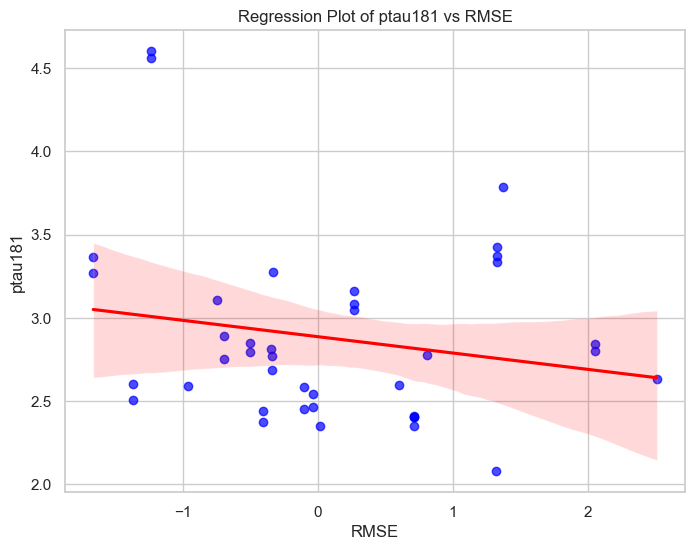

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.413
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.242
Time:                        14:38:10   Log-Likelihood:                -31.085
No. Observations:                  40   AIC:                             66.17
Df Residuals:                      38   BIC:                             69.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

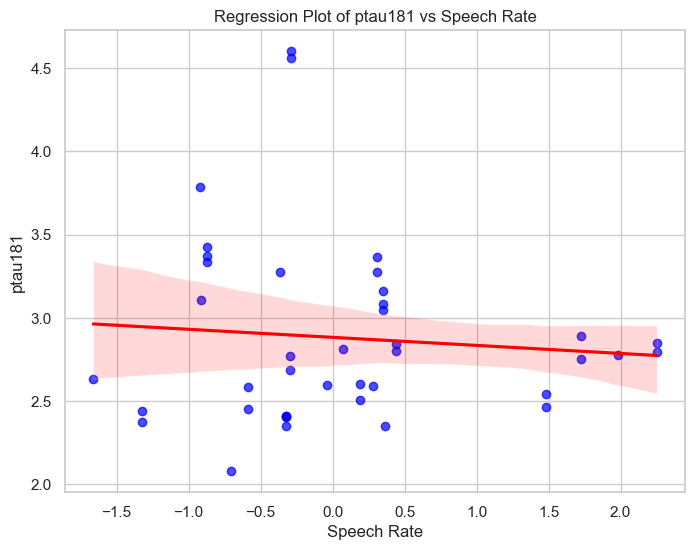

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.2937
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.591
Time:                        14:38:15   Log-Likelihood:                -31.662
No. Observations:                  40   AIC:                             67.32
Df Residuals:                      38   BIC:                             70.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

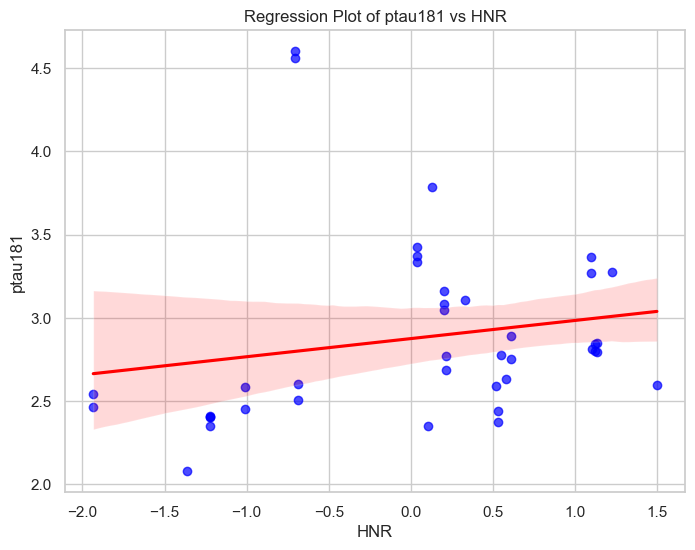

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.393
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.245
Time:                        14:40:13   Log-Likelihood:                -31.096
No. Observations:                  40   AIC:                             66.19
Df Residuals:                      38   BIC:                             69.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2

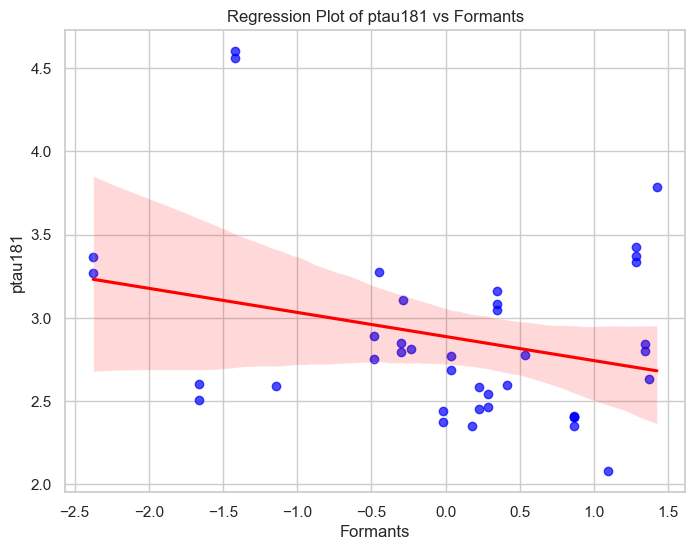

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.043
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0892
Time:                        14:40:16   Log-Likelihood:                -30.275
No. Observations:                  40   AIC:                             64.55
Df Residuals:                      38   BIC:                             67.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

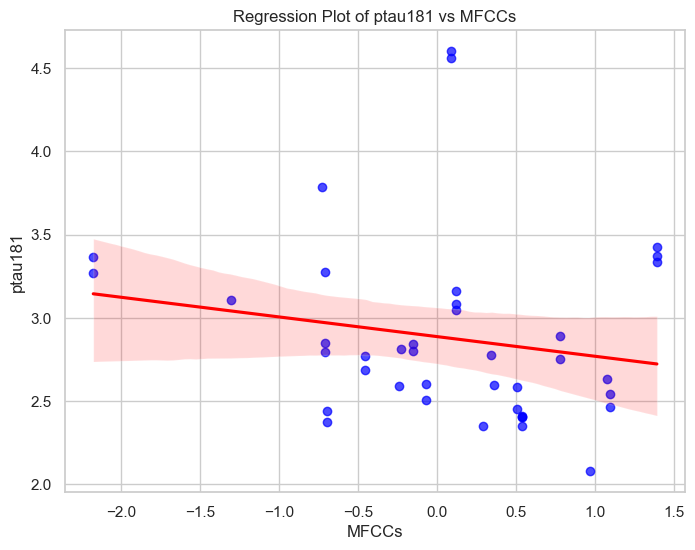

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.342
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.254
Time:                        14:40:22   Log-Likelihood:                -31.121
No. Observations:                  40   AIC:                             66.24
Df Residuals:                      38   BIC:                             69.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

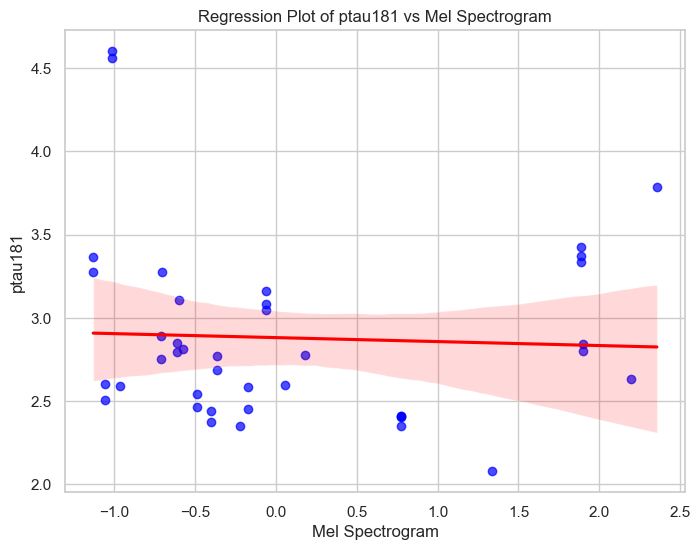

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                   0.08306
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.775
Time:                        14:40:27   Log-Likelihood:                -31.772
No. Observations:                  40   AIC:                             67.54
Df Residuals:                      38   BIC:                             70.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

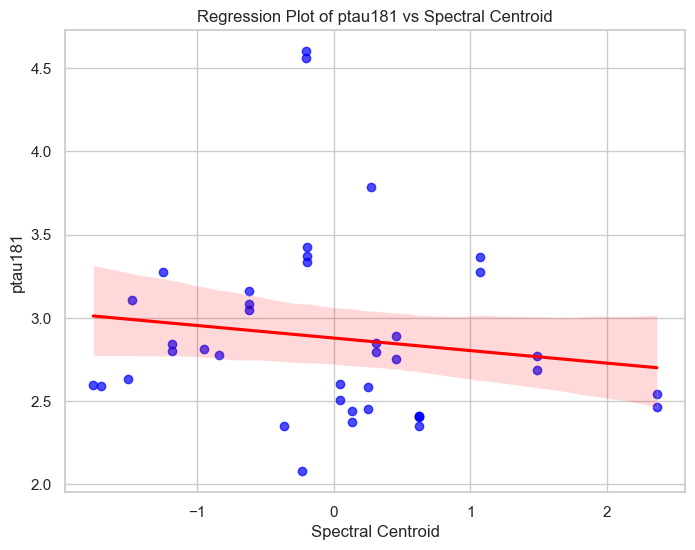

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7310
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.398
Time:                        14:40:33   Log-Likelihood:                -31.435
No. Observations:                  40   AIC:                             66.87
Df Residuals:                      38   BIC:                             70.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [11]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "M":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ptau181"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of ptau181 vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('ptau181')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [ ]:
#male ttau

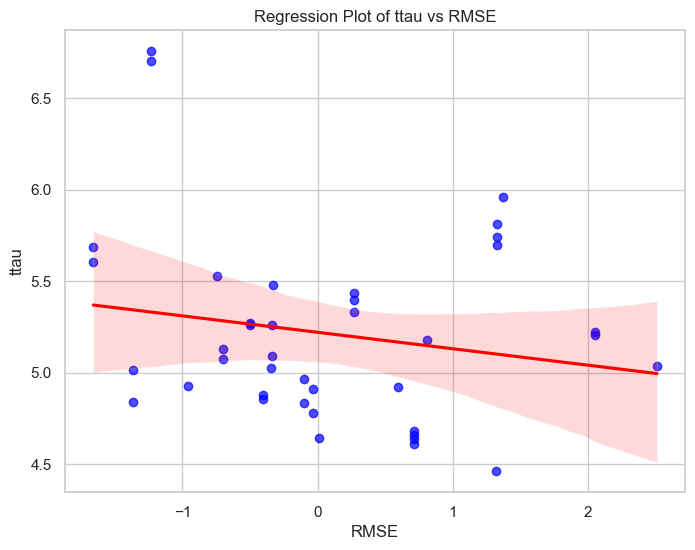

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.349
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.253
Time:                        14:44:21   Log-Likelihood:                -28.426
No. Observations:                  40   AIC:                             60.85
Df Residuals:                      38   BIC:                             64.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

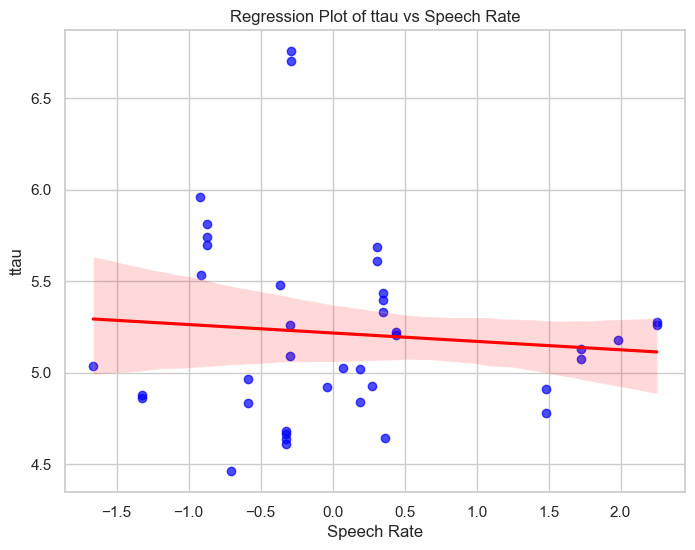

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.3041
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.585
Time:                        14:44:26   Log-Likelihood:                -28.964
No. Observations:                  40   AIC:                             61.93
Df Residuals:                      38   BIC:                             65.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

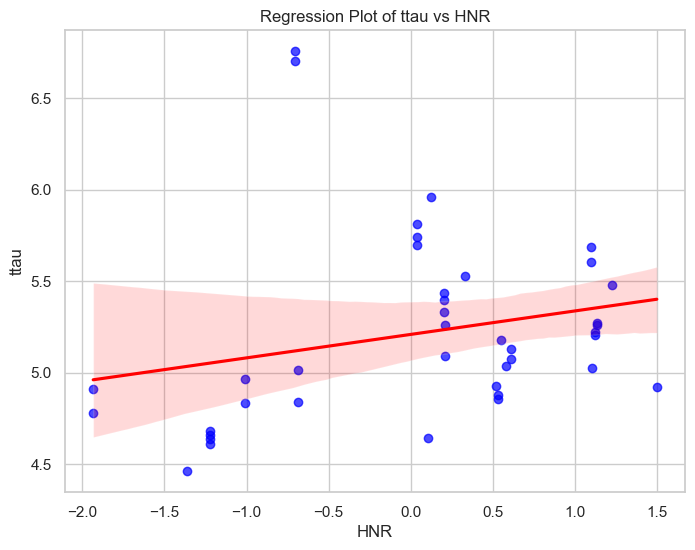

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.258
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.141
Time:                        14:46:23   Log-Likelihood:                -27.969
No. Observations:                  40   AIC:                             59.94
Df Residuals:                      38   BIC:                             63.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5

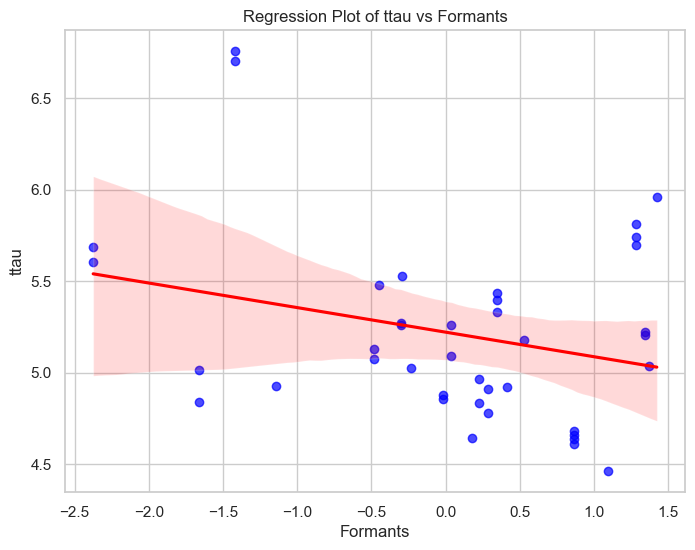

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.994
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0917
Time:                        14:46:27   Log-Likelihood:                -27.606
No. Observations:                  40   AIC:                             59.21
Df Residuals:                      38   BIC:                             62.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

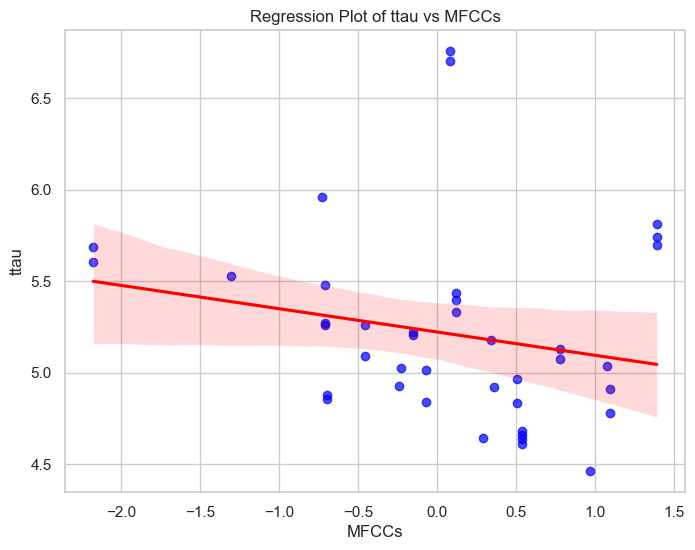

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.807
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.187
Time:                        14:46:33   Log-Likelihood:                -28.194
No. Observations:                  40   AIC:                             60.39
Df Residuals:                      38   BIC:                             63.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

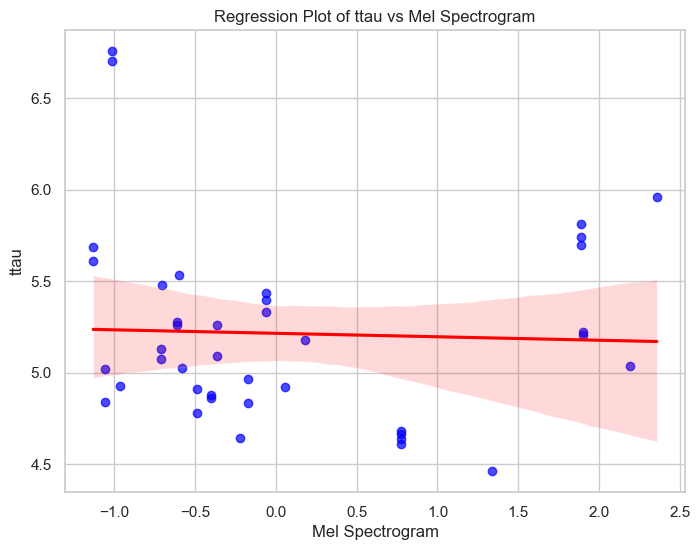

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                   0.06022
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.807
Time:                        14:46:38   Log-Likelihood:                -29.092
No. Observations:                  40   AIC:                             62.18
Df Residuals:                      38   BIC:                             65.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

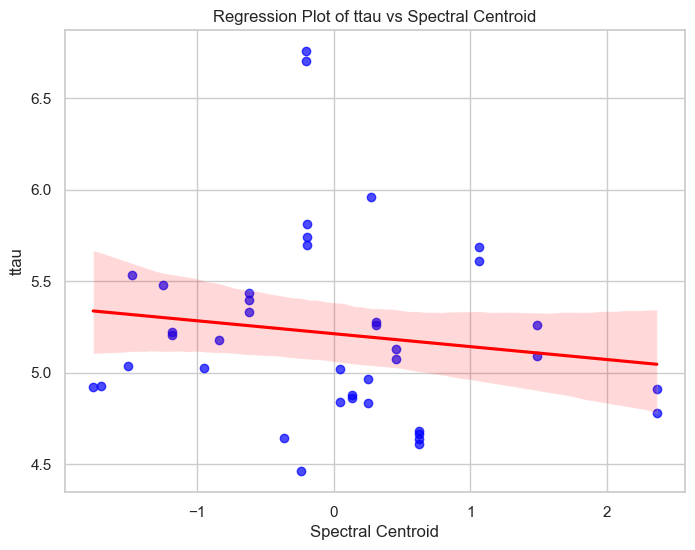

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7356
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.396
Time:                        14:46:43   Log-Likelihood:                -28.740
No. Observations:                  40   AIC:                             61.48
Df Residuals:                      38   BIC:                             64.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [13]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "M":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ttau"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of ttau vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('ttau')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [ ]:
#male ratio the p-tau/Aß42

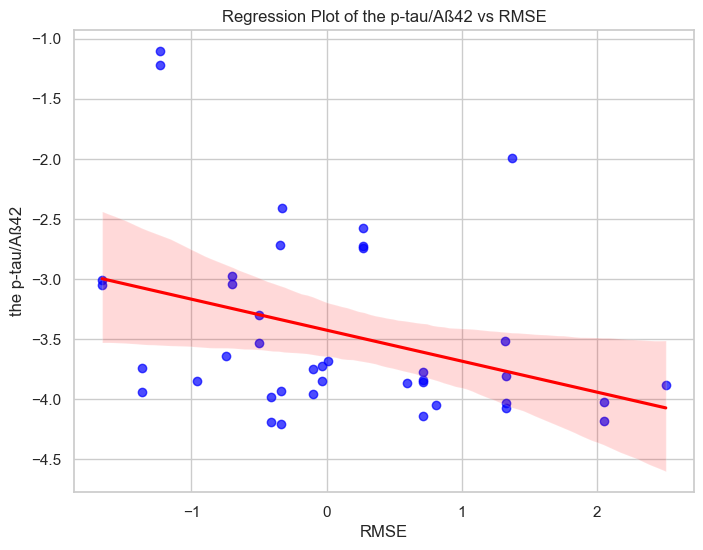

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.367
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0260
Time:                        14:53:15   Log-Likelihood:                -42.975
No. Observations:                  40   AIC:                             89.95
Df Residuals:                      38   BIC:                             93.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

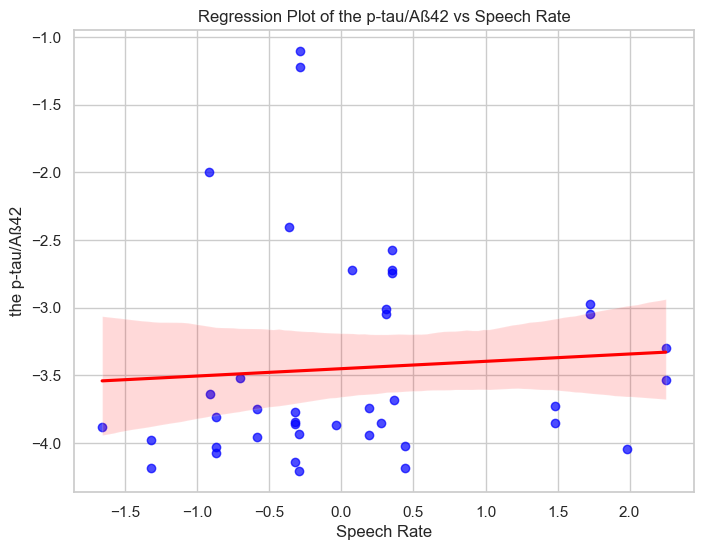

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.1847
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.670
Time:                        14:53:20   Log-Likelihood:                -45.521
No. Observations:                  40   AIC:                             95.04
Df Residuals:                      38   BIC:                             98.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

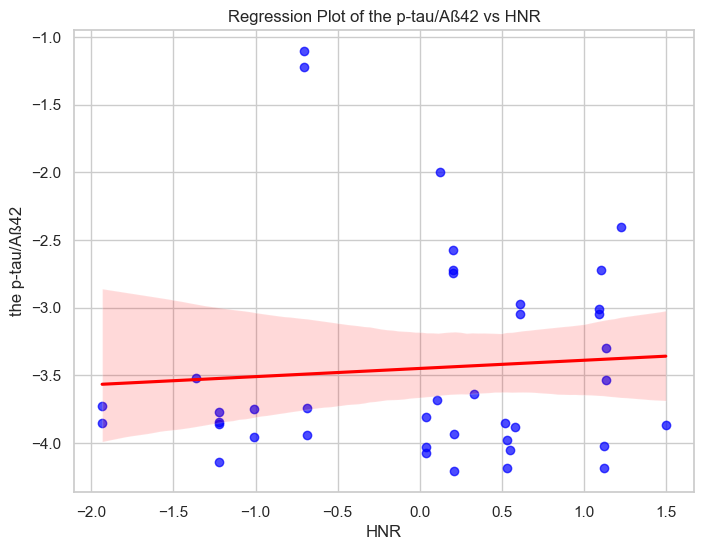

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.2088
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.650
Time:                        14:55:18   Log-Likelihood:                -45.508
No. Observations:                  40   AIC:                             95.02
Df Residuals:                      38   BIC:                             98.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3

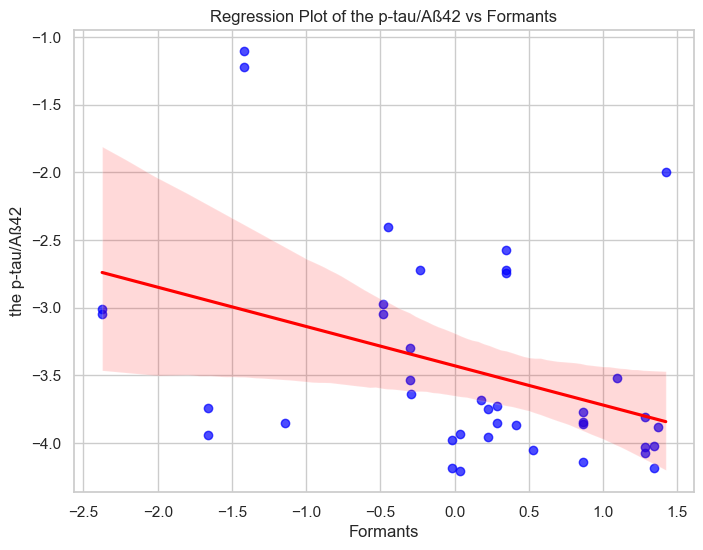

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     6.686
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0137
Time:                        14:55:21   Log-Likelihood:                -42.376
No. Observations:                  40   AIC:                             88.75
Df Residuals:                      38   BIC:                             92.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

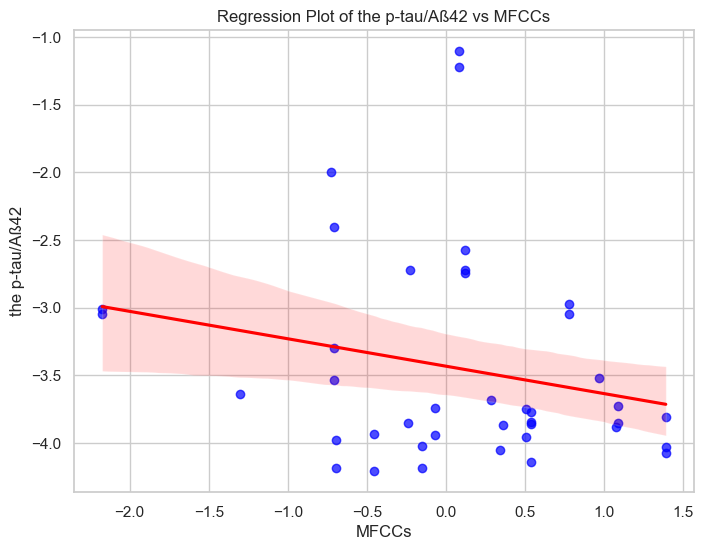

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.011
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.164
Time:                        14:55:27   Log-Likelihood:                -44.586
No. Observations:                  40   AIC:                             93.17
Df Residuals:                      38   BIC:                             96.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

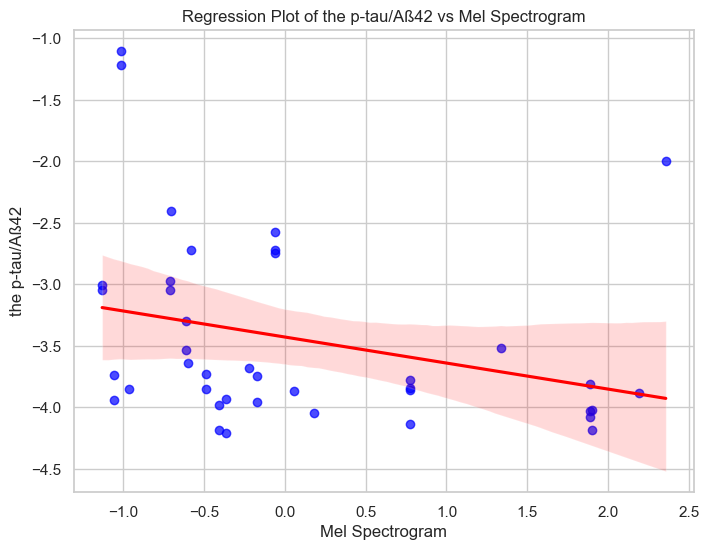

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.586
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0659
Time:                        14:55:32   Log-Likelihood:                -43.814
No. Observations:                  40   AIC:                             91.63
Df Residuals:                      38   BIC:                             95.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

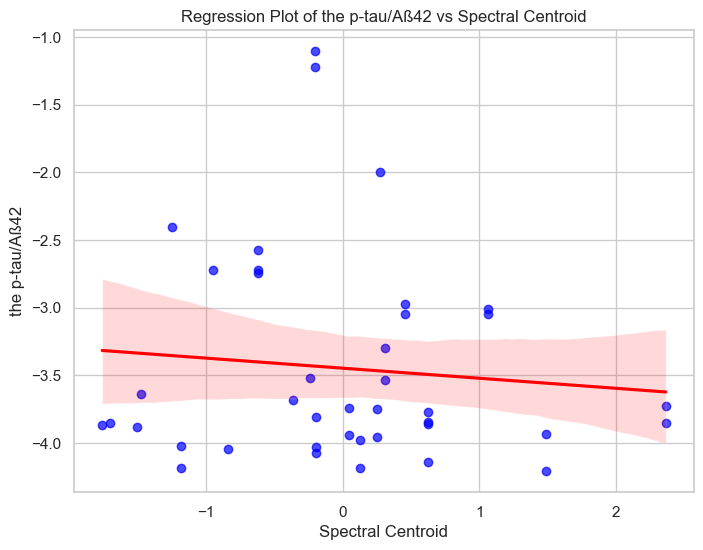

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.3536
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.556
Time:                        14:55:38   Log-Likelihood:                -45.433
No. Observations:                  40   AIC:                             94.87
Df Residuals:                      38   BIC:                             98.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [14]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "M":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ratio"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of the p-tau/Aß42 vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('the p-tau/Aß42')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [15]:
#females ptau 

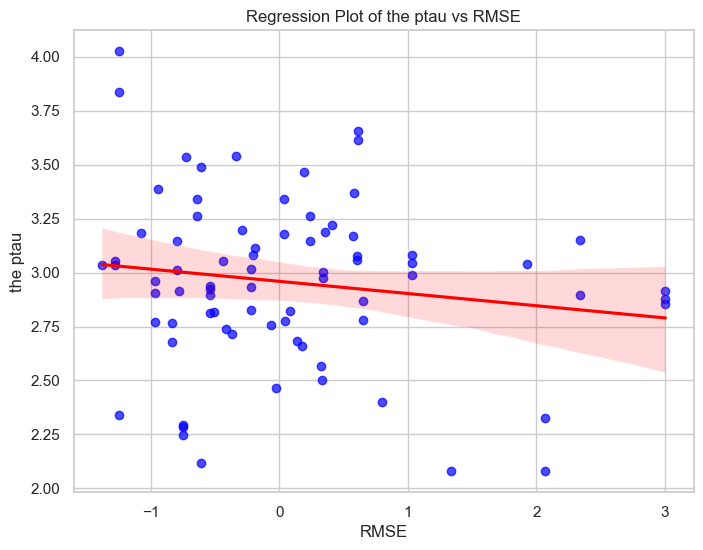

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.793
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.185
Time:                        15:06:29   Log-Likelihood:                -34.884
No. Observations:                  77   AIC:                             73.77
Df Residuals:                      75   BIC:                             78.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

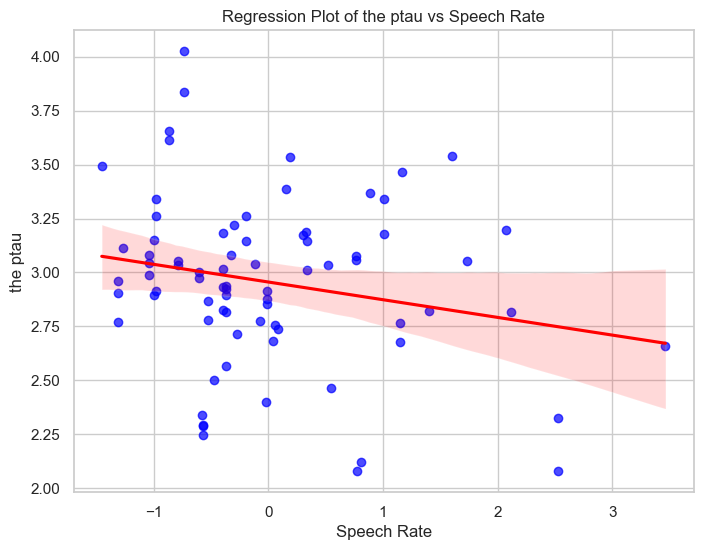

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.548
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0635
Time:                        15:06:38   Log-Likelihood:                -34.014
No. Observations:                  77   AIC:                             72.03
Df Residuals:                      75   BIC:                             76.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

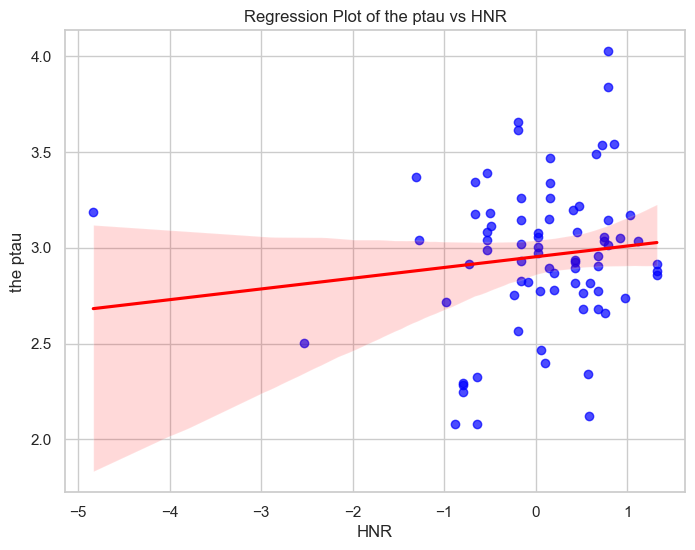

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.276
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.262
Time:                        15:10:33   Log-Likelihood:                -35.144
No. Observations:                  77   AIC:                             74.29
Df Residuals:                      75   BIC:                             78.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2

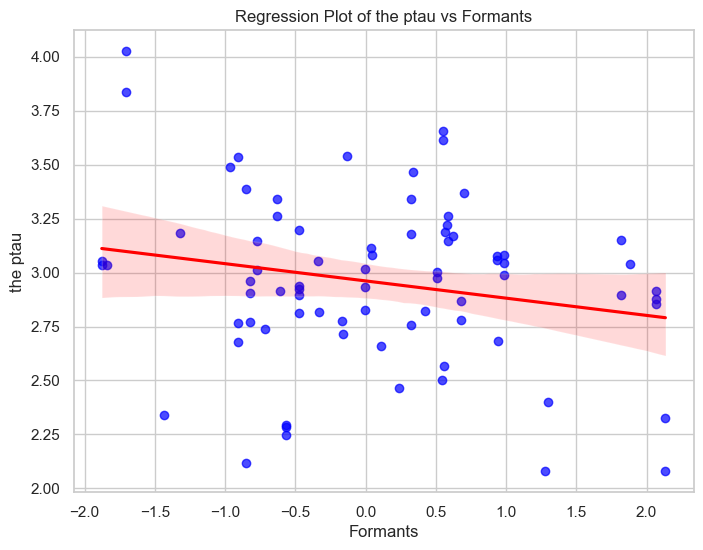

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.428
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0680
Time:                        15:10:40   Log-Likelihood:                -34.073
No. Observations:                  77   AIC:                             72.15
Df Residuals:                      75   BIC:                             76.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

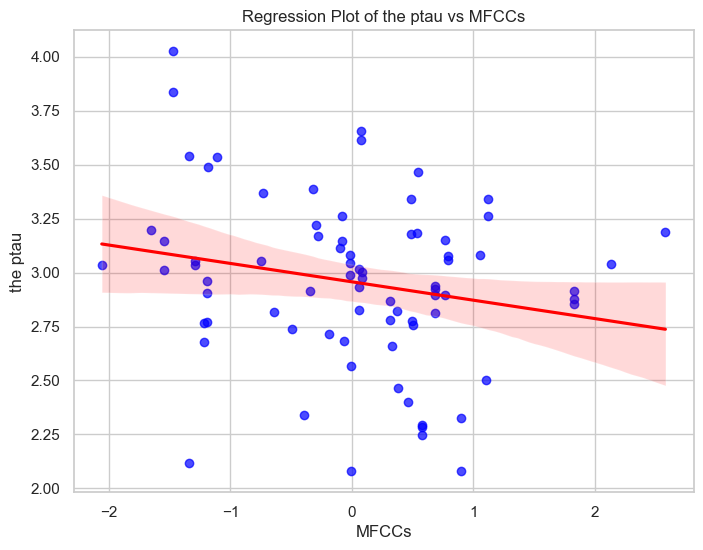

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.520
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0645
Time:                        15:10:51   Log-Likelihood:                -34.028
No. Observations:                  77   AIC:                             72.06
Df Residuals:                      75   BIC:                             76.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

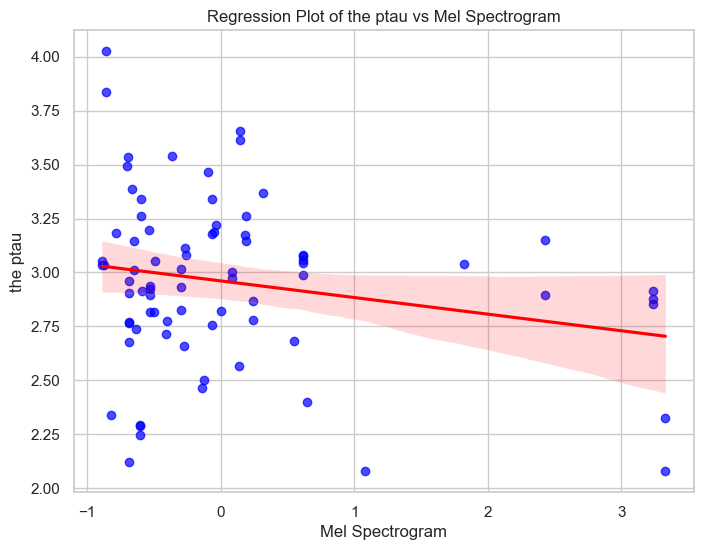

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.593
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0619
Time:                        15:11:02   Log-Likelihood:                -33.992
No. Observations:                  77   AIC:                             71.98
Df Residuals:                      75   BIC:                             76.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

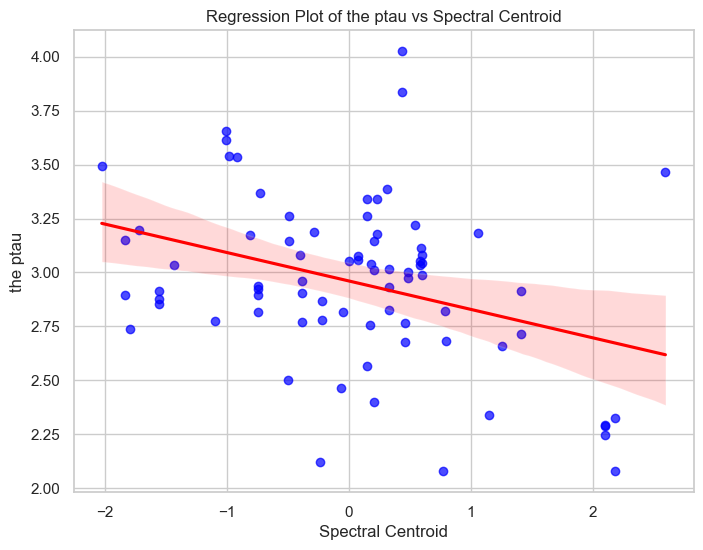

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     10.39
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00188
Time:                        15:11:12   Log-Likelihood:                -30.798
No. Observations:                  77   AIC:                             65.60
Df Residuals:                      75   BIC:                             70.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [16]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ptau181"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of the ptau vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('the ptau')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [17]:
#females ttau 

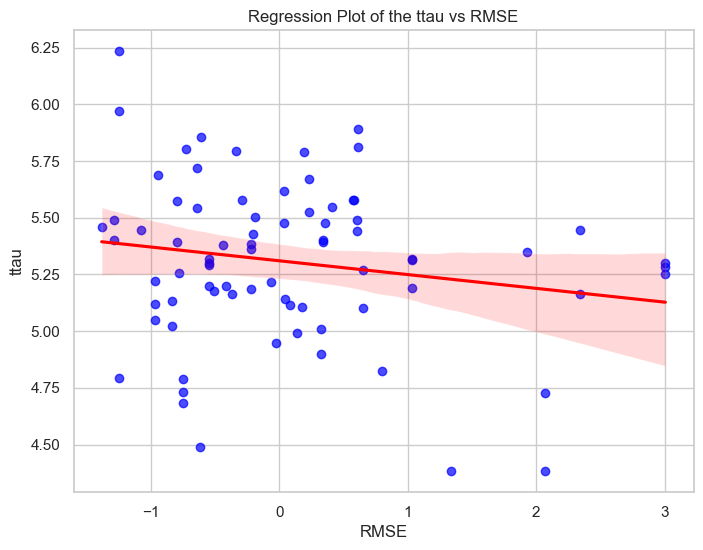

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.552
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.114
Time:                        15:36:04   Log-Likelihood:                -27.006
No. Observations:                  77   AIC:                             58.01
Df Residuals:                      75   BIC:                             62.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

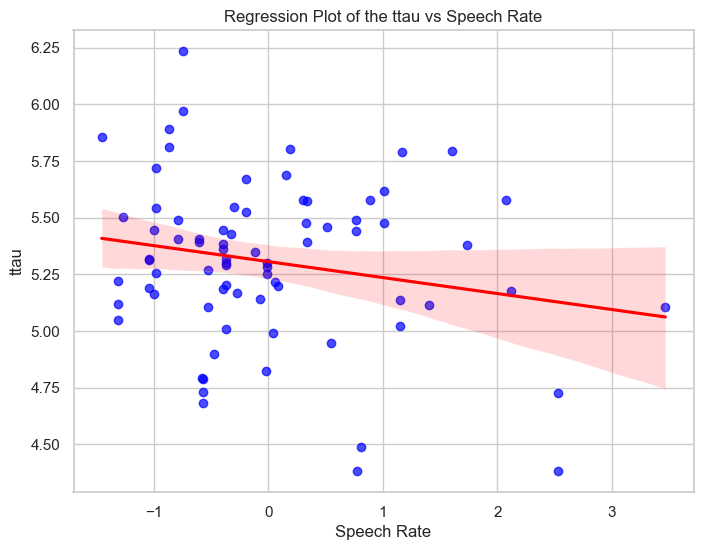

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.179
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0787
Time:                        15:36:13   Log-Likelihood:                -26.696
No. Observations:                  77   AIC:                             57.39
Df Residuals:                      75   BIC:                             62.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

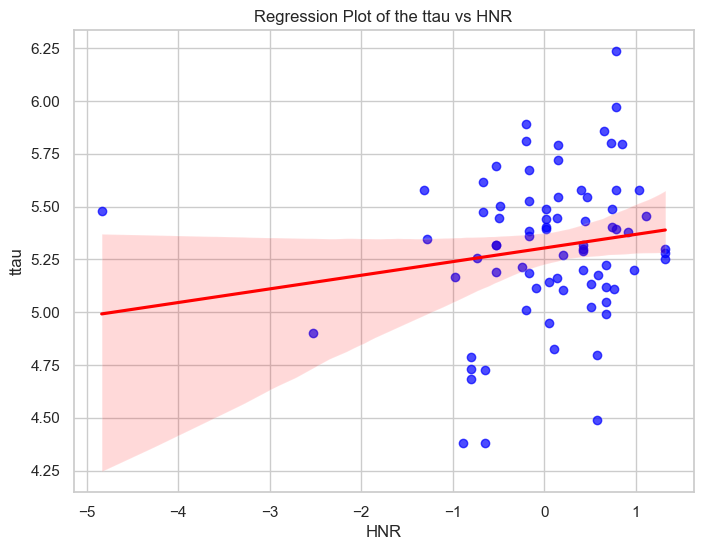

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.078
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.154
Time:                        15:40:00   Log-Likelihood:                -27.242
No. Observations:                  77   AIC:                             58.48
Df Residuals:                      75   BIC:                             63.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5

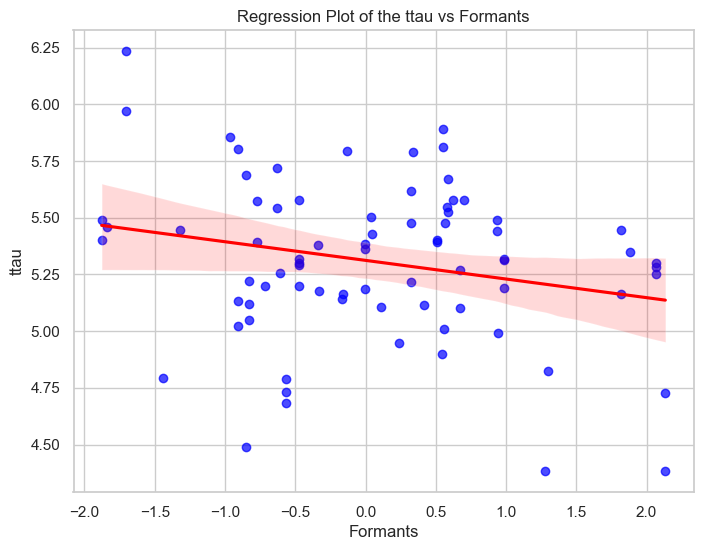

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.468
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0379
Time:                        15:40:08   Log-Likelihood:                -26.067
No. Observations:                  77   AIC:                             56.13
Df Residuals:                      75   BIC:                             60.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

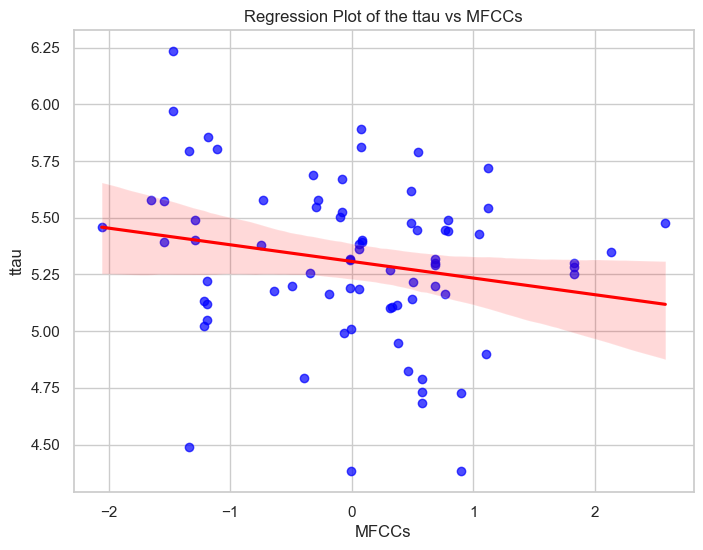

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.159
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0796
Time:                        15:40:18   Log-Likelihood:                -26.706
No. Observations:                  77   AIC:                             57.41
Df Residuals:                      75   BIC:                             62.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

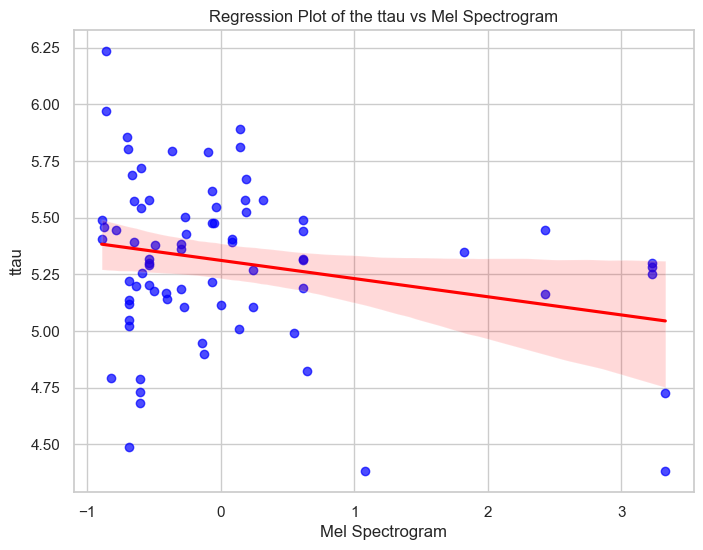

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     4.813
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0313
Time:                        15:40:29   Log-Likelihood:                -25.900
No. Observations:                  77   AIC:                             55.80
Df Residuals:                      75   BIC:                             60.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

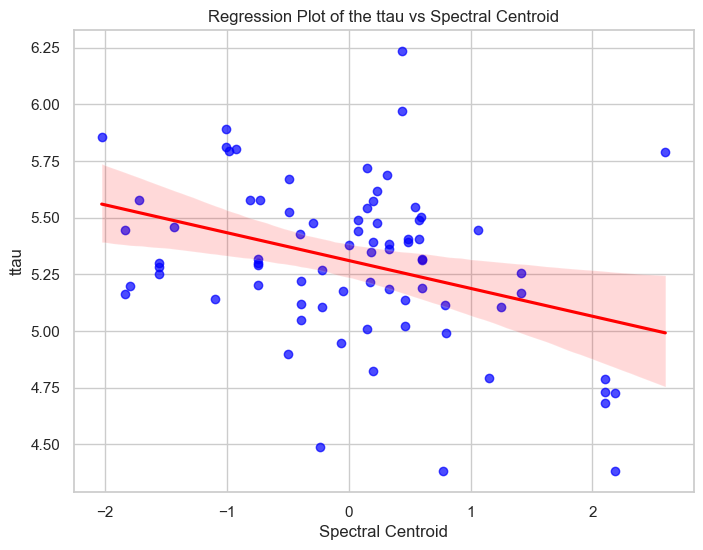

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     11.09
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00135
Time:                        15:40:39   Log-Likelihood:                -22.986
No. Observations:                  77   AIC:                             49.97
Df Residuals:                      75   BIC:                             54.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [18]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ttau"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of the ttau vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('ttau')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [19]:
#female ratio the p-tau/Aß42

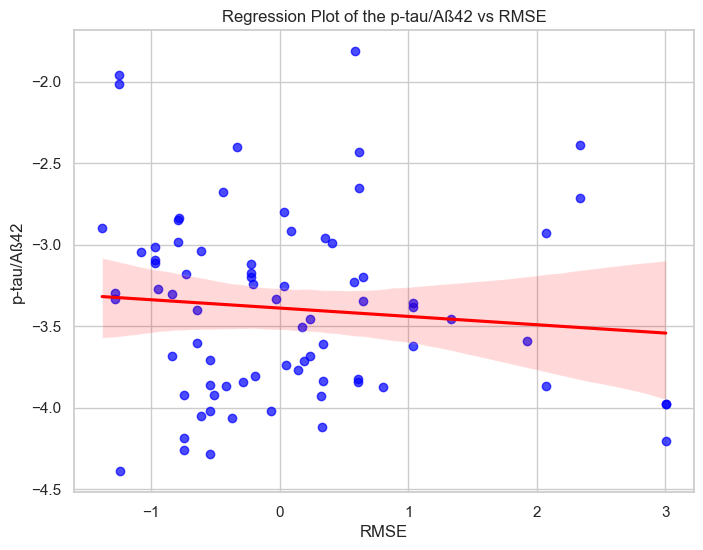

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6819
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.412
Time:                        15:48:04   Log-Likelihood:                -64.418
No. Observations:                  77   AIC:                             132.8
Df Residuals:                      75   BIC:                             137.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

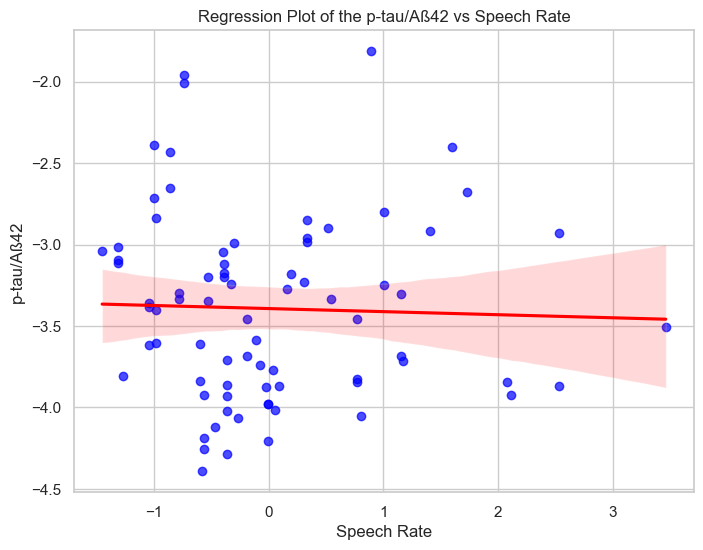

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.08454
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.772
Time:                        15:48:14   Log-Likelihood:                -64.723
No. Observations:                  77   AIC:                             133.4
Df Residuals:                      75   BIC:                             138.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

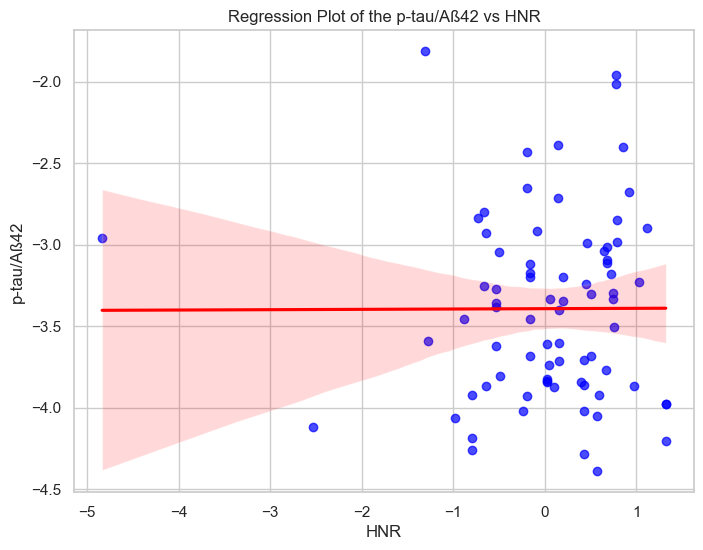

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                 0.0008188
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.977
Time:                        15:52:03   Log-Likelihood:                -64.766
No. Observations:                  77   AIC:                             133.5
Df Residuals:                      75   BIC:                             138.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3

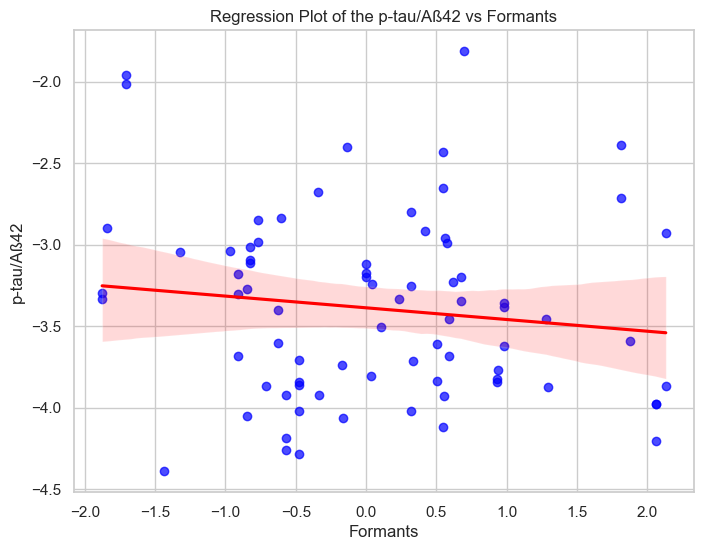

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.269
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.264
Time:                        15:52:10   Log-Likelihood:                -64.121
No. Observations:                  77   AIC:                             132.2
Df Residuals:                      75   BIC:                             136.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

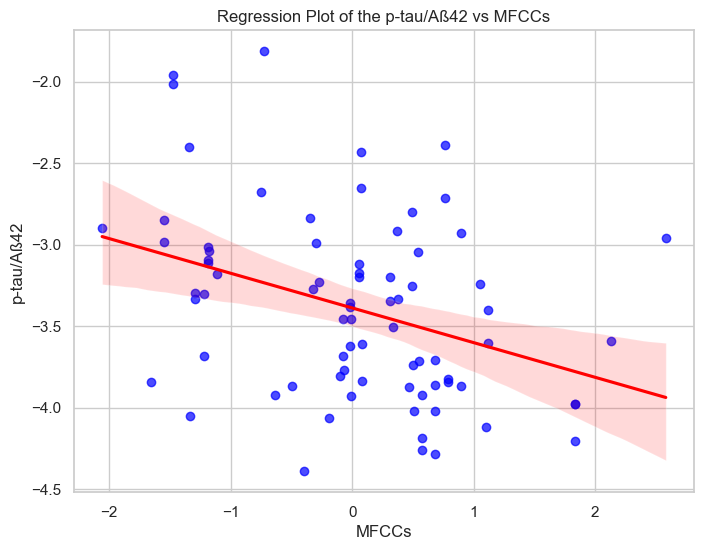

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     11.40
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00117
Time:                        15:52:22   Log-Likelihood:                -59.319
No. Observations:                  77   AIC:                             122.6
Df Residuals:                      75   BIC:                             127.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

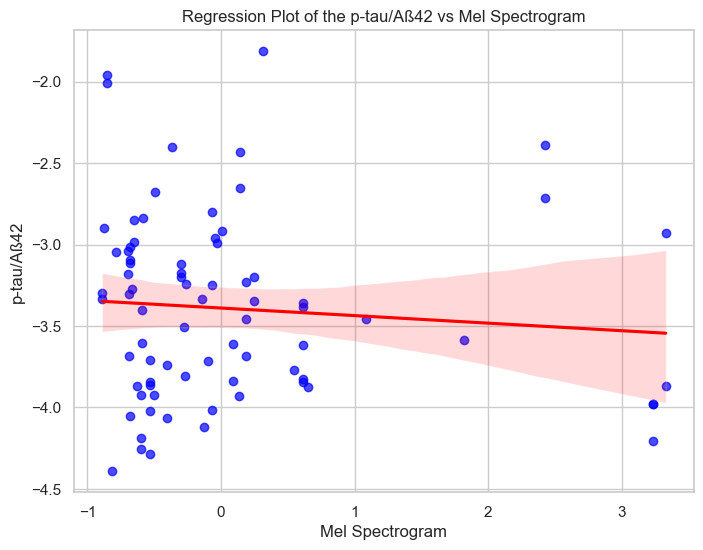

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5910
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.444
Time:                        15:52:36   Log-Likelihood:                -64.465
No. Observations:                  77   AIC:                             132.9
Df Residuals:                      75   BIC:                             137.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

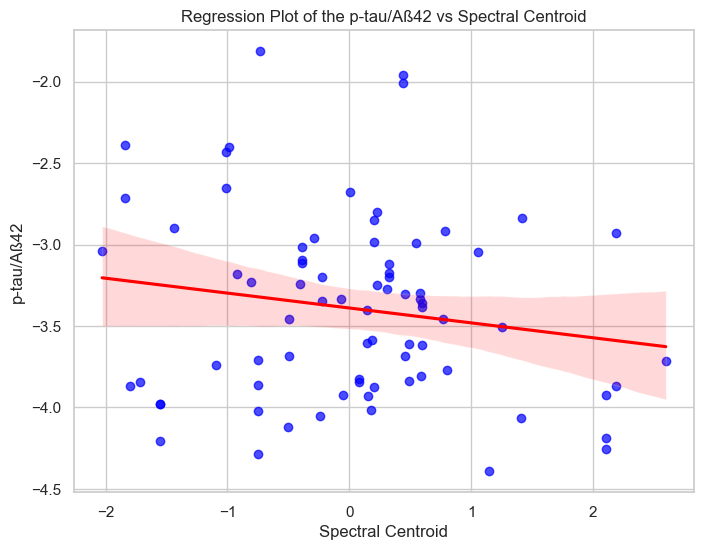

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.130
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.149
Time:                        15:52:46   Log-Likelihood:                -63.688
No. Observations:                  77   AIC:                             131.4
Df Residuals:                      75   BIC:                             136.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [20]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F":
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ratio"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of the p-tau/Aß42 vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('p-tau/Aß42')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [ ]:
#both genders ratio the p-tau/Aß42

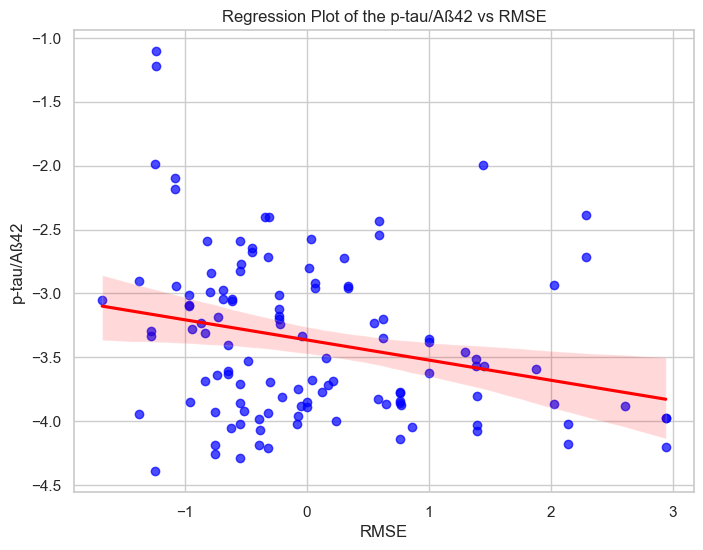

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     8.348
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00461
Time:                        15:54:05   Log-Likelihood:                -109.64
No. Observations:                 118   AIC:                             223.3
Df Residuals:                     116   BIC:                             228.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

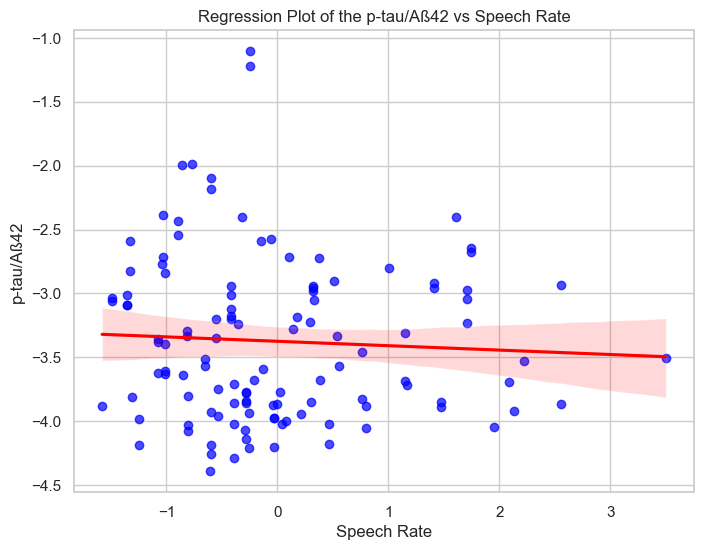

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3605
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.549
Time:                        15:54:19   Log-Likelihood:                -113.56
No. Observations:                 118   AIC:                             231.1
Df Residuals:                     116   BIC:                             236.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

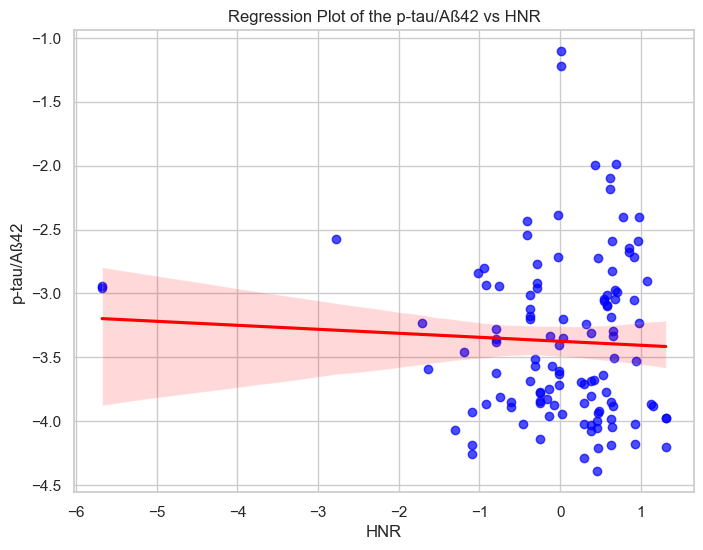

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2999
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.585
Time:                        16:00:20   Log-Likelihood:                -113.59
No. Observations:                 118   AIC:                             231.2
Df Residuals:                     116   BIC:                             236.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3

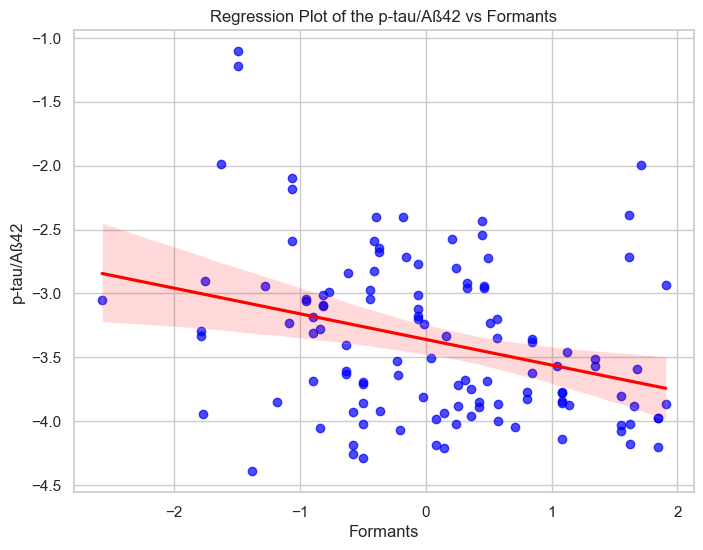

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     12.36
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           0.000627
Time:                        16:00:31   Log-Likelihood:                -107.77
No. Observations:                 118   AIC:                             219.5
Df Residuals:                     116   BIC:                             225.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

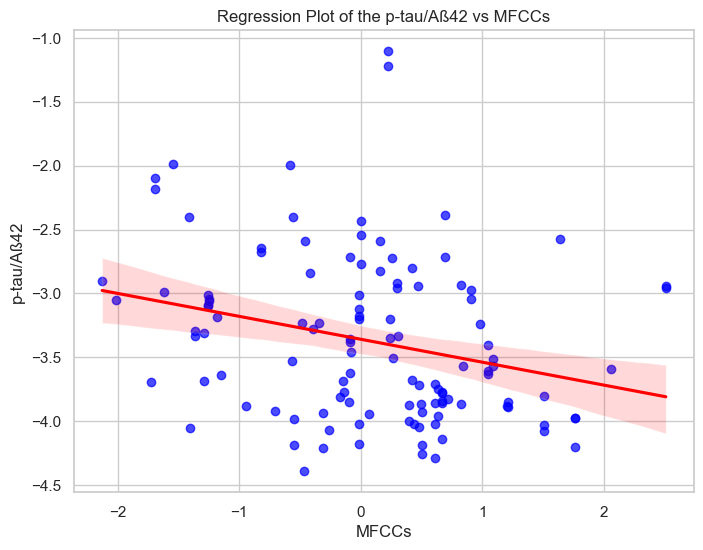

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     9.189
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00300
Time:                        16:00:47   Log-Likelihood:                -109.24
No. Observations:                 118   AIC:                             222.5
Df Residuals:                     116   BIC:                             228.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

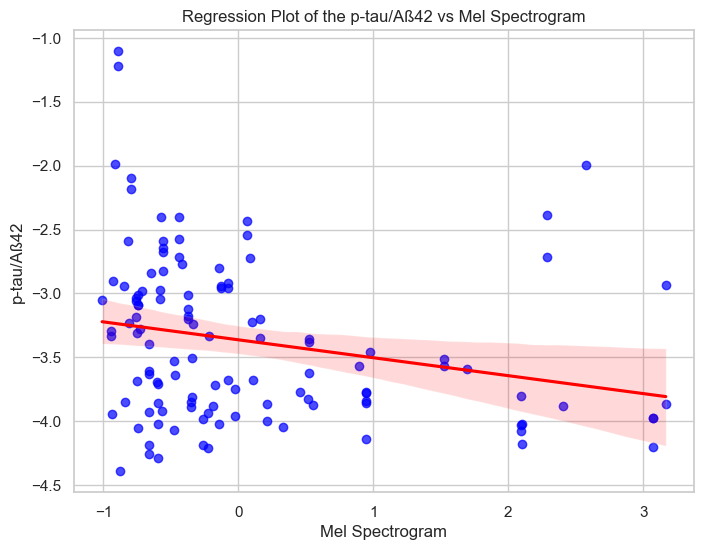

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     6.954
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00951
Time:                        16:01:03   Log-Likelihood:                -110.31
No. Observations:                 118   AIC:                             224.6
Df Residuals:                     116   BIC:                             230.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

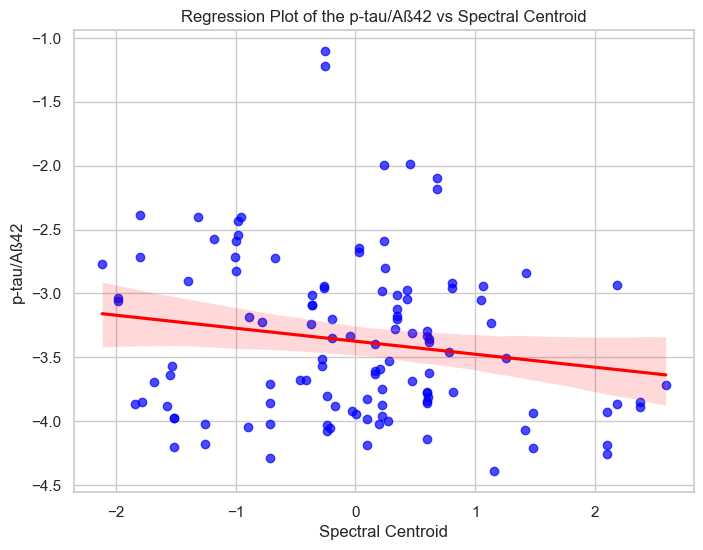

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     3.336
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0704
Time:                        16:01:19   Log-Likelihood:                -112.07
No. Observations:                 118   AIC:                             228.1
Df Residuals:                     116   BIC:                             233.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [21]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F" and sex != "M" :
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ratio"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of the p-tau/Aß42 vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('p-tau/Aß42')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [ ]:
#both genders  p-tau

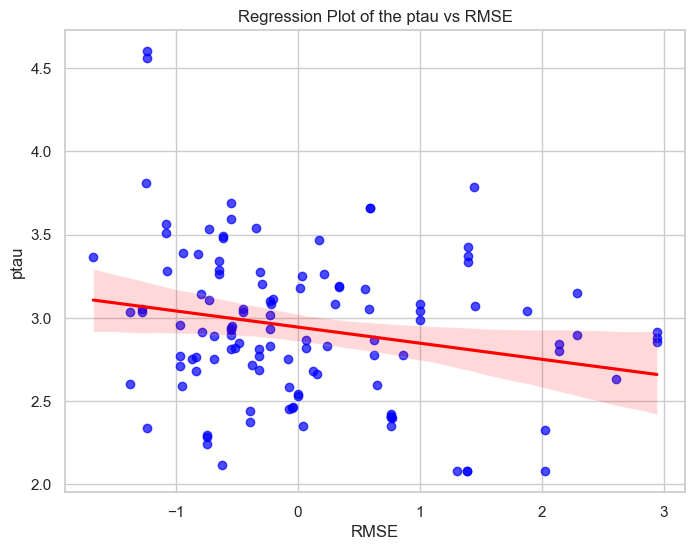

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5.963
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0161
Time:                        16:02:02   Log-Likelihood:                -71.751
No. Observations:                 118   AIC:                             147.5
Df Residuals:                     116   BIC:                             153.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

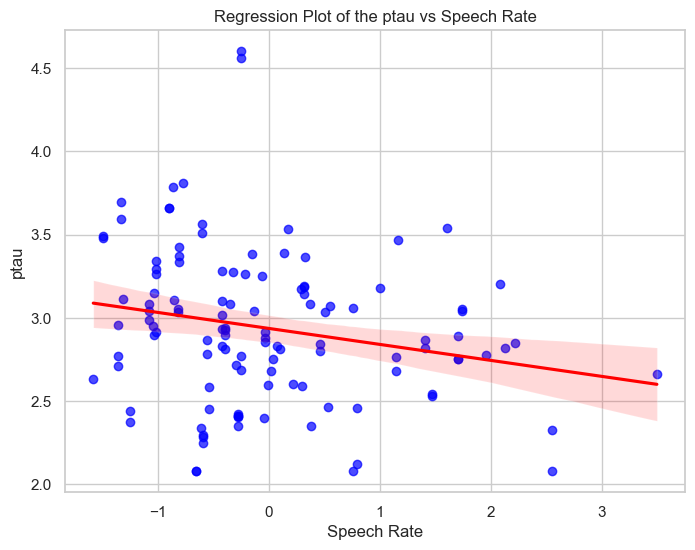

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     5.654
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0190
Time:                        16:02:16   Log-Likelihood:                -71.901
No. Observations:                 118   AIC:                             147.8
Df Residuals:                     116   BIC:                             153.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

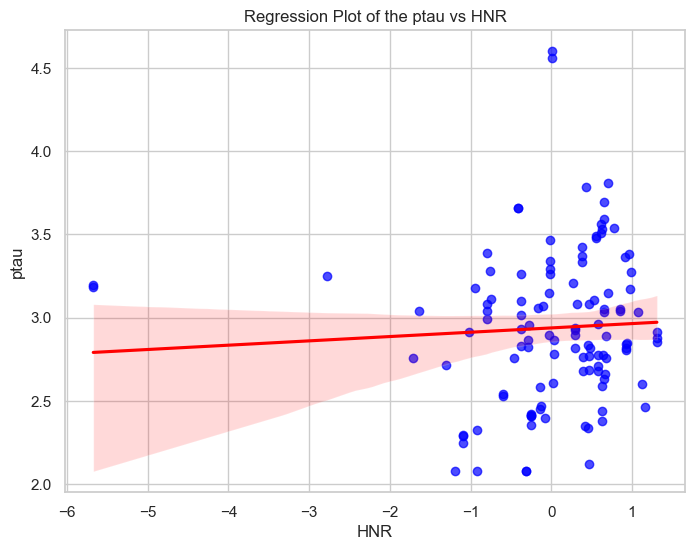

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.4007
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.528
Time:                        16:08:31   Log-Likelihood:                -74.505
No. Observations:                 118   AIC:                             153.0
Df Residuals:                     116   BIC:                             158.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2

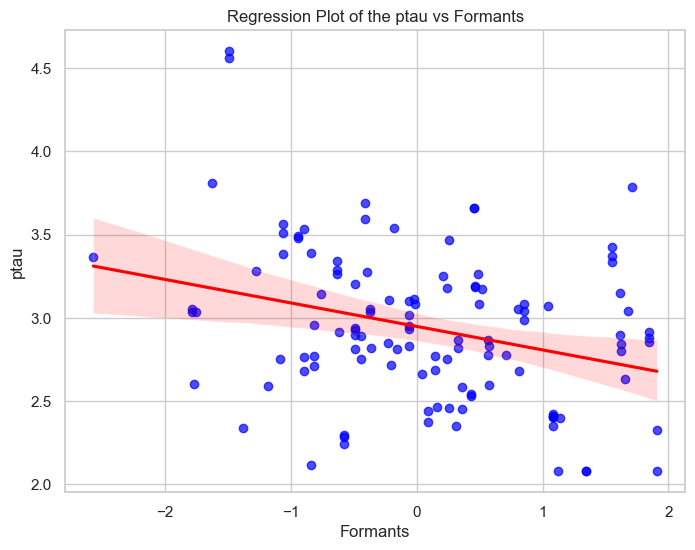

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     11.77
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           0.000835
Time:                        16:08:42   Log-Likelihood:                -69.007
No. Observations:                 118   AIC:                             142.0
Df Residuals:                     116   BIC:                             147.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

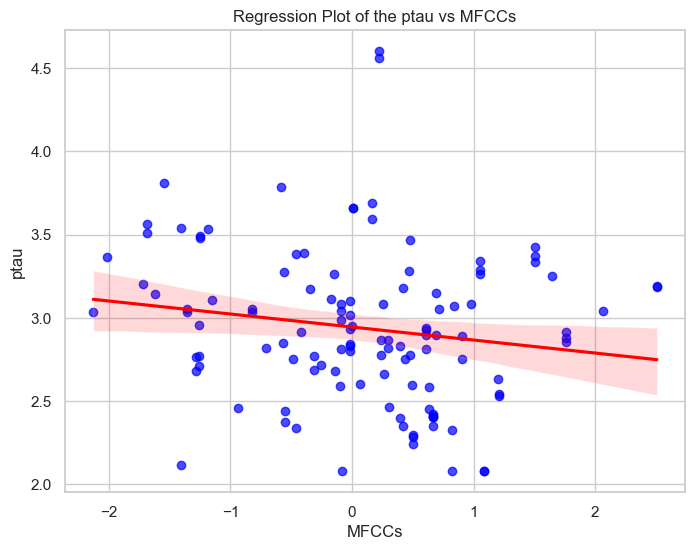

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.214
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0756
Time:                        16:09:02   Log-Likelihood:                -73.096
No. Observations:                 118   AIC:                             150.2
Df Residuals:                     116   BIC:                             155.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

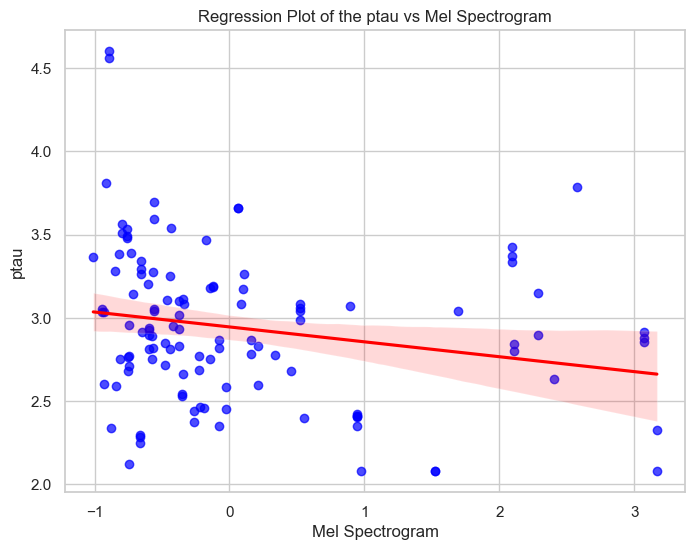

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     5.412
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0217
Time:                        16:09:22   Log-Likelihood:                -72.018
No. Observations:                 118   AIC:                             148.0
Df Residuals:                     116   BIC:                             153.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

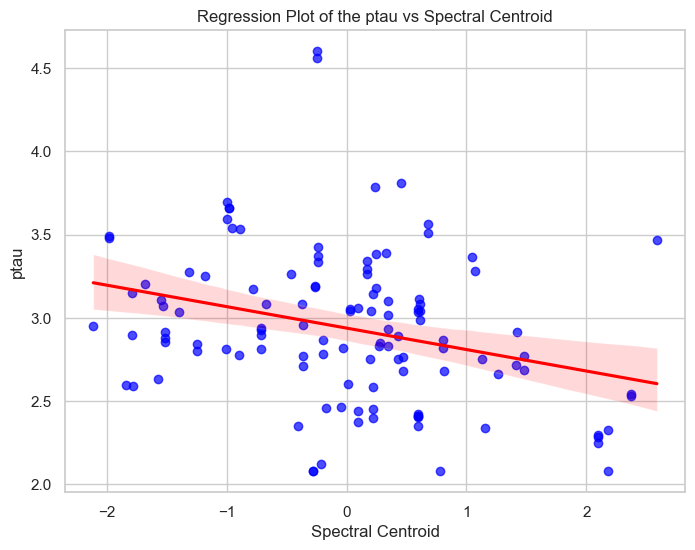

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     11.02
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00121
Time:                        16:09:38   Log-Likelihood:                -69.356
No. Observations:                 118   AIC:                             142.7
Df Residuals:                     116   BIC:                             148.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [22]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F" and sex != "M" :
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ptau181"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of the ptau vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('ptau')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


In [ ]:
#ttau in both genders

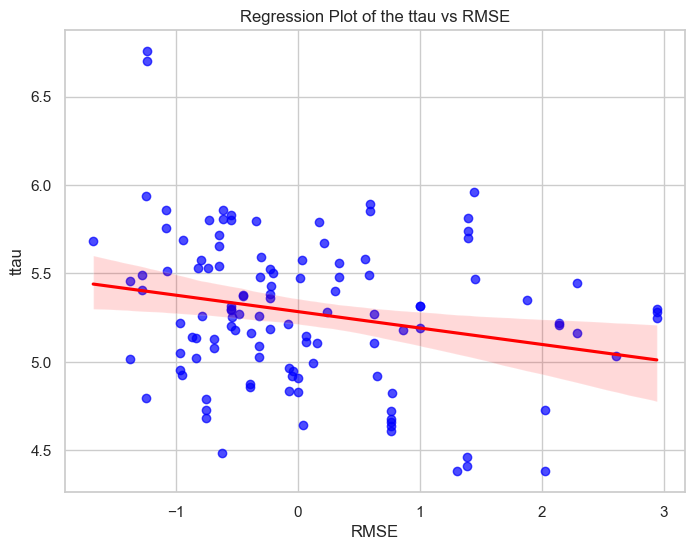

Regression results for feature: RMSE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.434
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0125
Time:                        16:10:31   Log-Likelihood:                -62.428
No. Observations:                 118   AIC:                             128.9
Df Residuals:                     116   BIC:                             134.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

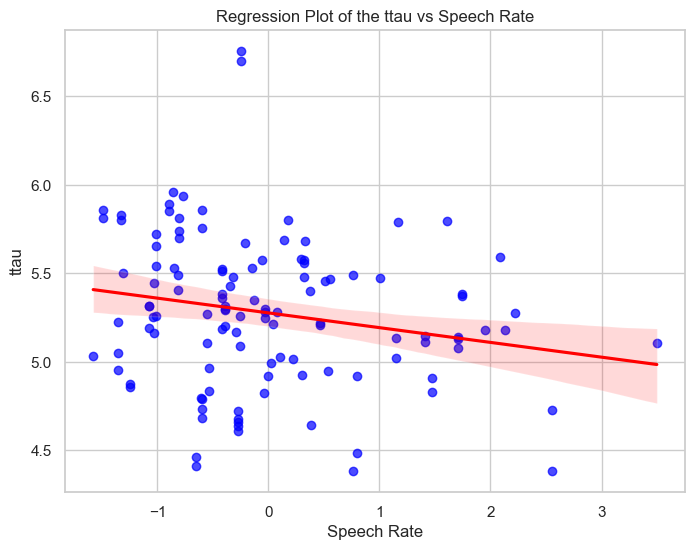

Regression results for feature: Speech Rate
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.950
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0280
Time:                        16:10:46   Log-Likelihood:                -63.147
No. Observations:                 118   AIC:                             130.3
Df Residuals:                     116   BIC:                             135.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

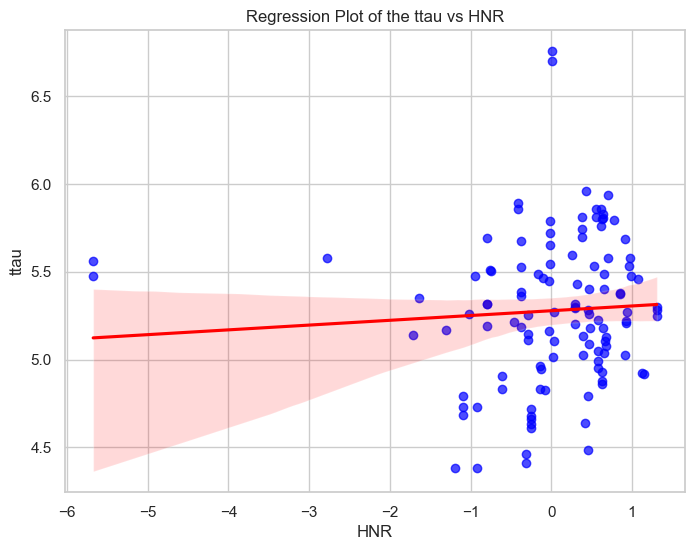

Regression results for feature: HNR
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5155
Date:                Thu, 29 Feb 2024   Prob (F-statistic):              0.474
Time:                        16:16:58   Log-Likelihood:                -65.351
No. Observations:                 118   AIC:                             134.7
Df Residuals:                     116   BIC:                             140.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5

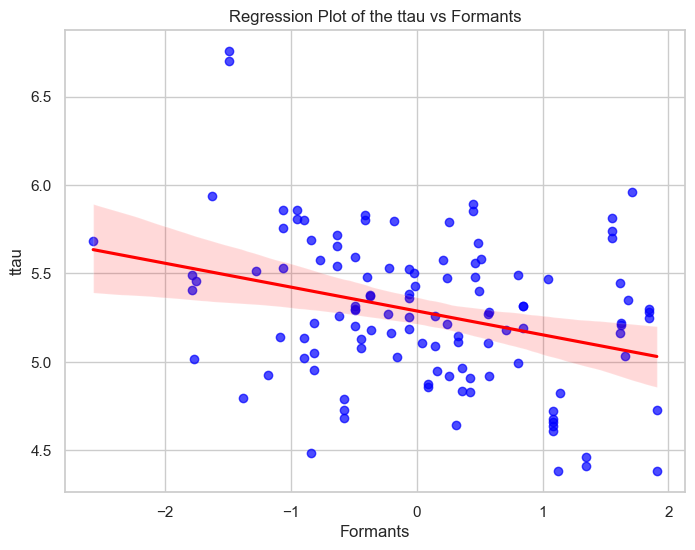

Regression results for feature: Formants
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     12.64
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           0.000547
Time:                        16:17:09   Log-Likelihood:                -59.510
No. Observations:                 118   AIC:                             123.0
Df Residuals:                     116   BIC:                             128.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

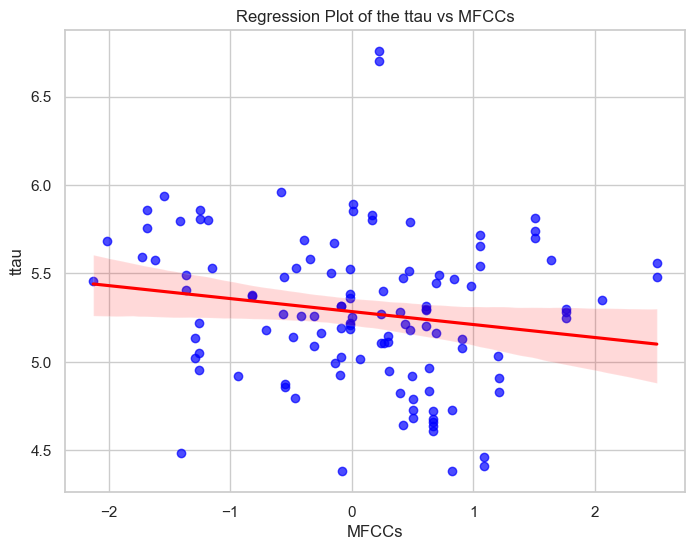

Regression results for feature: MFCCs
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.309
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0715
Time:                        16:17:25   Log-Likelihood:                -63.953
No. Observations:                 118   AIC:                             131.9
Df Residuals:                     116   BIC:                             137.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

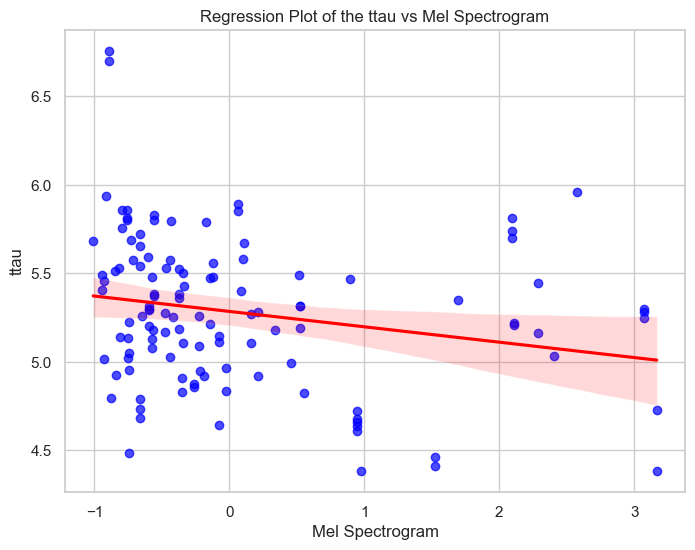

Regression results for feature: Mel Spectrogram
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5.987
Date:                Thu, 29 Feb 2024   Prob (F-statistic):             0.0159
Time:                        16:17:41   Log-Likelihood:                -62.644
No. Observations:                 118   AIC:                             129.3
Df Residuals:                     116   BIC:                             134.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

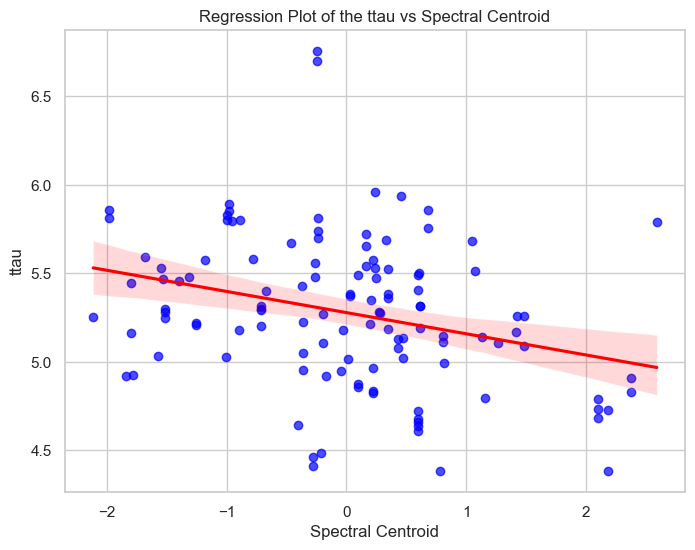

Regression results for feature: Spectral Centroid
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     11.11
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00115
Time:                        16:17:57   Log-Likelihood:                -60.215
No. Observations:                 118   AIC:                             124.4
Df Residuals:                     116   BIC:                             130.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [23]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pydub import AudioSegment
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = data_df2

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features and ptau181 values for male patients
    all_data = []
    ptau181_values = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if  sex != "F" and sex != "M" :
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                # Get the ptau181 value for the male patient
                ptau181_value = row["ttau"]

                all_data.append(feature_value)
                ptau181_values.append(np.log(ptau181_value))

                break  # Break after finding the first matching audio file

    # Convert the lists to NumPy arrays
    X = np.array(all_data)
    y = np.array(ptau181_values)

    # Reshape X to be a 2D array
    X = X.reshape(-1, 1)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Adding a constant to the independent variables matrix
    X_train_with_const = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train_with_const).fit()

    # Plot the regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=X_train_with_const[:, 1], y=y_train, scatter_kws={'alpha': 0.7}, color='blue', line_kws={'color': 'red'})
    plt.title(f'Regression Plot of the ttau vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('ttau')
    plt.show()

    # Print the regression results for the current feature
    print(f"Regression results for feature: {feature}")
    print(model.summary())


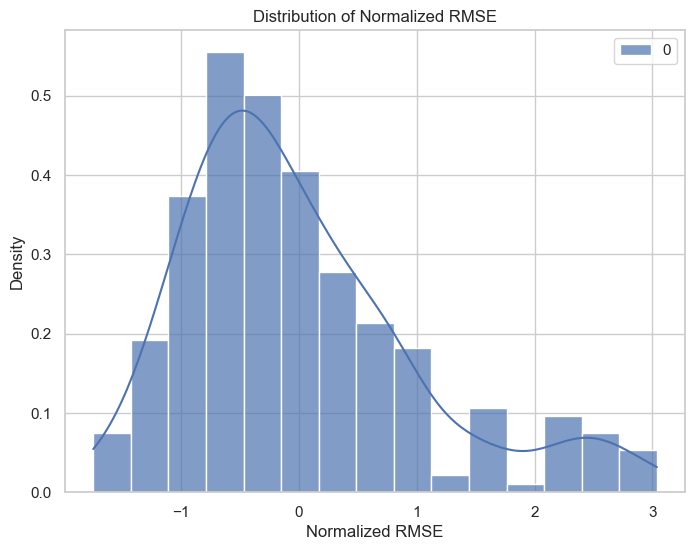

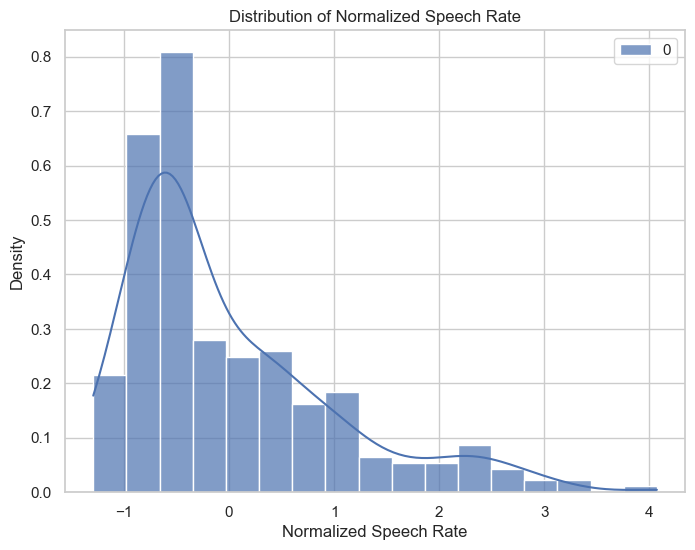

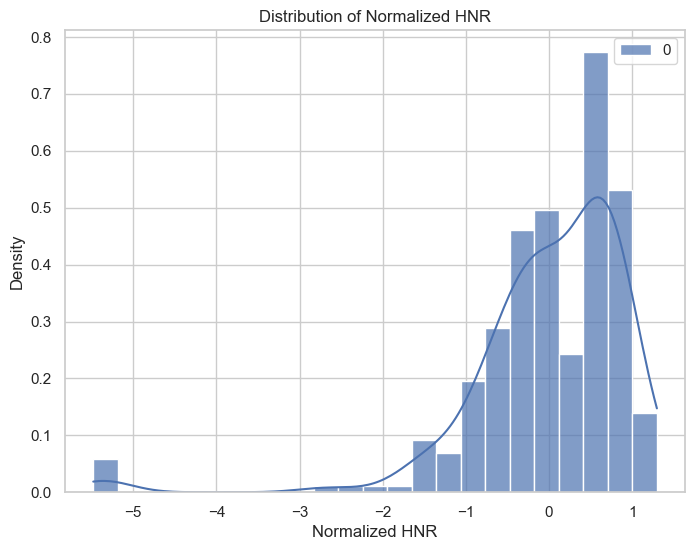

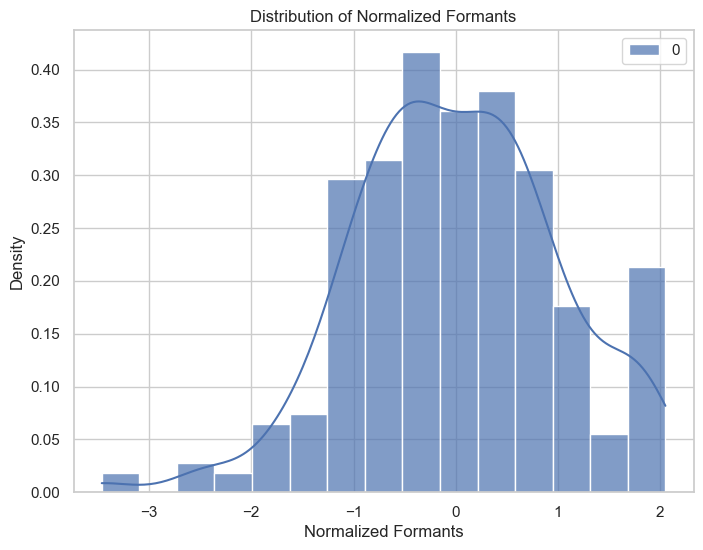

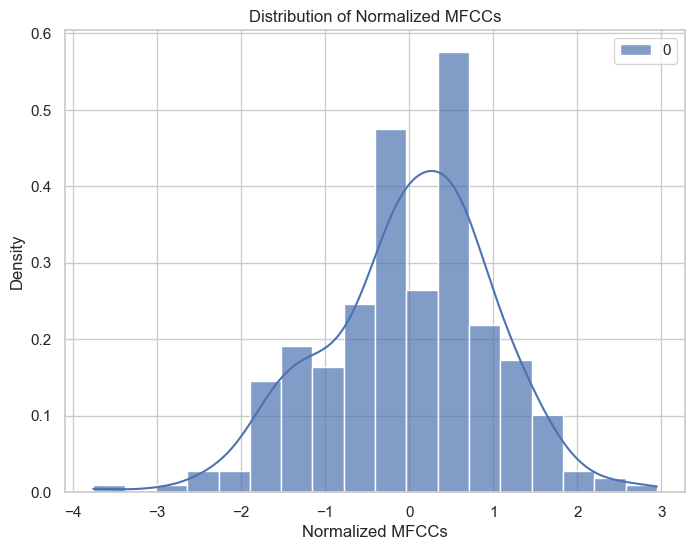

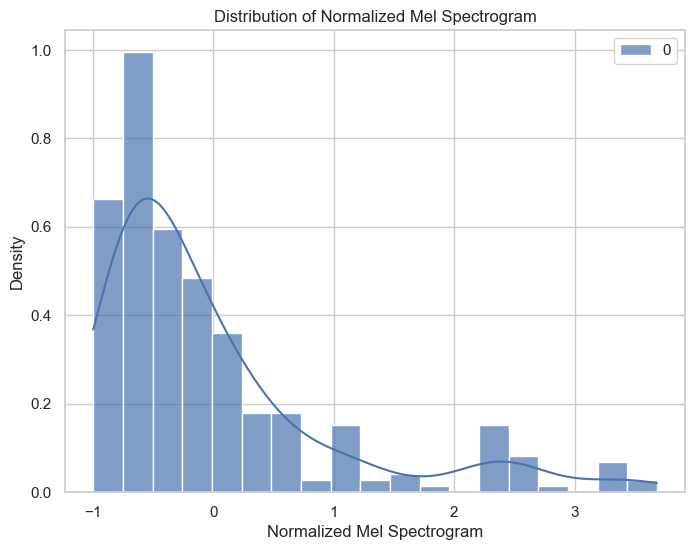

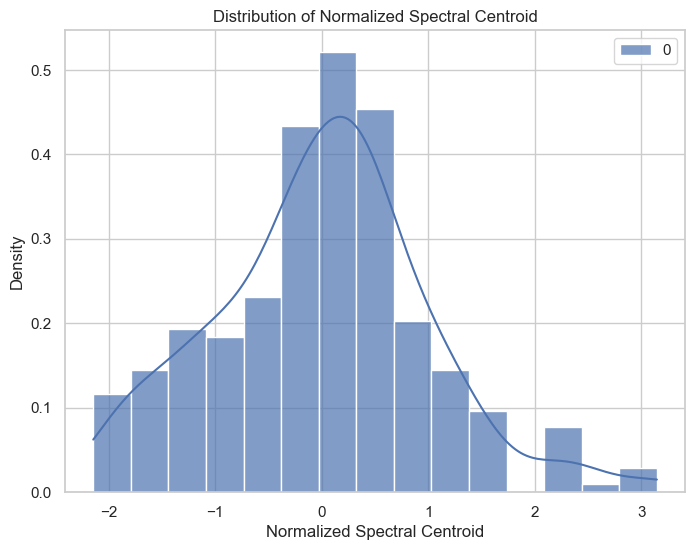

In [27]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = pd.read_excel(excel_path)

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Iterate over each feature
for feature in features:
    # Lists to store extracted features
    all_data = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if sex not in ["F", "M"]:
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                all_data.append(feature_value)

    # Convert the list to a NumPy array
    X = np.array(all_data)

    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, 1))

    # Plot the distribution of the normalized feature
    plt.figure(figsize=(8, 6))
    sns.histplot(X_scaled, kde=True, stat="density", color='skyblue', alpha=0.7)

    plt.title(f'Distribution of Normalized {feature}')
    plt.xlabel(f'Normalized {feature}')
    plt.ylabel('Density')
    plt.show()


In [29]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Folder containing the audio files
audio_folder = "/Volumes/MyBook/ADRC/Segmented ADRC Audio/All"

# Load the data from Excel into a DataFrame
excel_path = "/Volumes/MyBook/ADRC/csf_2022_averaged_labels_AD.xlsx"
data_df = pd.read_excel(excel_path)

# Define a list of features
features = ["RMSE", "Speech Rate", "HNR", "Formants", "MFCCs", "Mel Spectrogram", "Spectral Centroid"]

# Create a DataFrame to store R-squared values
r_squared_df = pd.DataFrame(columns=['Feature', 'R-squared'])

# Iterate over each feature
for feature in features:
    # Lists to store extracted features
    all_data = []

    # Loop through patient IDs in the DataFrame
    for idx, row in data_df.iterrows():
        patient_id = row["PatientID"]
        sex = row["Sex"]

        # Filter data for male patients
        if sex not in ["F", "M"]:
            continue

        # Iterate through audio files in the folder
        for filename in os.listdir(audio_folder):
            if filename.startswith(f"{patient_id}_") and filename.endswith(".wav"):
                audio_filepath = os.path.join(audio_folder, filename)

                # Load the audio file
                y, sr = librosa.load(audio_filepath)

                # Extract the feature based on the current iteration
                if feature == "RMSE":
                    feature_value = np.mean(librosa.feature.rms(y=y))
                elif feature == "Speech Rate":
                    feature_value = len(librosa.effects.split(y)) / (len(y) / sr) * 60
                elif feature == "HNR":
                    hnr = librosa.effects.harmonic(y)
                    feature_value = np.mean(hnr)
                elif feature == "Formants":
                    sound = AudioSegment.from_wav(audio_filepath)
                    feature_value = np.mean(sound.dBFS)
                elif feature == "MFCCs":
                    mfccs = librosa.feature.mfcc(y=y, sr=sr)
                    feature_value = np.mean(mfccs)
                elif feature == "Mel Spectrogram":
                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
                    feature_value = np.mean(mel_spectrogram)
                elif feature == "Spectral Centroid":
                    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
                    feature_value = np.mean(spectral_centroids)

                all_data.append(feature_value)

    # Convert the list to a NumPy array
    X = np.array(all_data).reshape(-1, 1)

    # Apply power transformation
    power_transformer = PowerTransformer()
    X_transformed = power_transformer.fit_transform(X)

    # Initialize a linear regression model
    model = LinearRegression()

    # Fit the model
    model.fit(X_transformed, X)

    # Calculate R-squared value
    r_squared = model.score(X_transformed, X)

    # Store the R-squared value in the DataFrame
    r_squared_df = r_squared_df.append({'Feature': feature, 'R-squared': r_squared}, ignore_index=True)

# Plot the R-squared values
plt.figure(figsize=(10, 6))
sns.barplot(data=r_squared_df, x='Feature', y='R-squared', palette='viridis')
plt.title('R-squared Values for Each Feature')
plt.xlabel('Feature')
plt.ylabel('R-squared')
plt.xticks(rotation=45)
plt.show()


/var/folders/rt/783n5n1x27l_6xpbtd8k7g540000gn/T/ipykernel_5961/1834975926.py:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_squared_df = r_squared_df.append({'Feature': feature, 'R-squared': r_squared}, ignore_index=True)
/var/folders/rt/783n5n1x27l_6xpbtd8k7g540000gn/T/ipykernel_5961/1834975926.py:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r_squared_df = r_squared_df.append({'Feature': feature, 'R-squared': r_squared}, ignore_index=True)


KeyboardInterrupt: 